In [1]:
#@title imports
import os
import pandas as pd
import numpy as np

from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data.dataset import Dataset  # For custom datasets
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision.models as models
from tqdm import tqdm
from torch.hub import load_state_dict_from_url
from torchvision import models
import math

C:\Users\aotia\anaconda3\envs\aging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title loss
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_one_hot(label, num_classes):
    batch_size = label.shape[0]
    onehot_label = torch.zeros((batch_size, num_classes))
    onehot_label = onehot_label.scatter_(1, label.unsqueeze(1).detach().cpu(), 1)
    onehot_label = (onehot_label.type(torch.FloatTensor)).to(label.device)
    return onehot_label

class FocalLoss(nn.Module):

    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction = self.reduction
        )

class FocalLoss2(nn.Module):

    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        self.num_classes = 5
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, target_tensor):
        eps = 1e-6
        label = get_one_hot(target_tensor, self.num_classes)
        #p = self.sigmoid(input_tensor)
        p = torch.clamp(self.sigmoid(input_tensor), min=eps, max=1-eps)
        focal_weights = torch.pow((1-p)*label + p * (1-label), self.gamma)
        loss = F.binary_cross_entropy_with_logits(input_tensor, label, reduction = 'none') * focal_weights
        loss = (loss ).sum() / input_tensor.shape[0]
        return loss

class CBFocalLoss(nn.Module):

    def __init__(self, weight=None,
                 gamma=2., beta = 0.999, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.beta = beta
        self.reduction = reduction
        self.classlist = [1.0, 176.0, 911.0, 215.0, 41.0]#[75, 1414, 905, 242, 84]
        self.num_classes = 5
        self.sigmoid = nn.Sigmoid()
        self.class_balanced_weight = np.array([(1-self.beta)/(1- self.beta ** N) for N in self.classlist])
        self.class_balanced_weight = torch.FloatTensor(self.class_balanced_weight / np.sum(self.class_balanced_weight) * self.num_classes*10).to("cuda")

    def forward(self, input_tensor, target_tensor):
        eps = 1e-6
        weight = (self.class_balanced_weight[target_tensor]).to("cuda")
        label = get_one_hot(target_tensor, self.num_classes)
        p = torch.clamp(self.sigmoid(input_tensor), min=eps, max=1-eps)
        focal_weights = torch.pow((1-p)*label + p * (1-label), self.gamma)
        loss = F.binary_cross_entropy_with_logits(input_tensor, label, reduction = 'none') * focal_weights
        loss = (loss * weight.view(-1, 1)).sum() / input_tensor.shape[0]
        return loss

class CBCrossEntropy(nn.Module):

    def __init__(self, weight=None,
                 beta = 0.999, reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.beta = beta
        self.reduction = reduction
        self.classlist = [75, 1414, 905, 242, 84]
        self.num_classes = 5
        self.sigmoid = nn.Sigmoid()
        self.class_balanced_weight = np.array([(1-self.beta)/(1- self.beta ** N) for N in self.classlist])
        self.class_balanced_weight = torch.FloatTensor(self.class_balanced_weight / np.sum(self.class_balanced_weight) * self.num_classes).to("cuda")

    def forward(self, input_tensor, target_tensor):
        eps = 1e-6
        weights = (self.class_balanced_weight).to("cuda")

        loss = F.cross_entropy(input_tensor, target_tensor, weight=weights)
        return loss

In [16]:
#@title dataset
class FishDataset(Dataset):
    def __init__(self, csv_path, dataset_dir, transform=None):
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=0)

        # Get the directory dataset images
        self.dataset_dir = dataset_dir

        # Get the transform methods
        self.transforms = transform


        # Image Name
        self.image_name = np.asarray(self.data_info.iloc[:, 2])


        # Otolith length
        self.length = np.asarray(self.data_info.iloc[:, 6])

        # Otolith weight
        self.wt = np.asarray(self.data_info.iloc[:, 7])

        # Month
        self.month = np.asarray(self.data_info.iloc[:, 4])

        # Fish Age
        self.age = np.asarray(self.data_info.iloc[:, 8])

        print(len(self.age), len(self.image_name))

    def __len__(self):
        return len(self.data_info.index)

    def __getitem__(self, index):
        #img_path = os.path.join(self.dataset_dir, str(self.image_name[index]) + '.jpg')
        #image = Image.open(img_path)
        wt_l_m = torch.tensor([(self.wt[index] - 163)/(82), (self.length[index] - 211)/ (35.5), (self.month[index]-7.4)/(1.9)])
        if(self.age[index] < 5):
          label_age = self.age[index]
        else:
          label_age = 4
        #label = torch.from_numpy(np.array(label_age))

        #if self.transforms:
        #    image = self.transforms(image)

        return (wt_l_m,wt_l_m) , label_age


In [17]:
#@title load data
from torch.utils.data import DataLoader

data_dir = 'F:/Scales/Atlantic Menhaden'
train_csv_path = os.path.join(data_dir, 'Atlantic_Menhaden_Train_Data.csv')
test_csv_path = os.path.join(data_dir, 'Atlantic_Menhaden_Test_Data.csv')
val_csv_path = os.path.join(data_dir, 'Atlantic_Menhaden_Val_Data.csv')
gulf_train_csv_path = os.path.join(data_dir,"Gulf Menhaden/gulf_train.csv")
gulf_test_csv_path = os.path.join(data_dir,"Gulf Menhaden/gulf_test.csv")
img_dir = os.path.join(data_dir, 'Cropped Images')
img_dir_gulf = os.path.join(data_dir, 'Gulf Menhaden/Gulf Cropped')


data_transforms_train = transforms.Compose(
        [
            transforms.Resize(299),
            transforms.RandomCrop(299),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees = 20),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

data_transforms = transforms.Compose(
        [
            transforms.Resize(299),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )

train_dataset = FishDataset(train_csv_path, img_dir, data_transforms_train)
class_weight = np.array([1.0/75.0, 1.0/1414, 1.0/905, 1.0/242, 1.0/84])*1414
samples_weight = np.array([class_weight[min(t,4)] for t in train_dataset.age])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
#print(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(FishDataset(train_csv_path, img_dir, data_transforms_train)))


#train_loader = DataLoader(FishDataset(gulf_train_csv_path, img_dir_gulf, data_transforms_train), batch_size=32, shuffle=True, drop_last=True)
#train_loader = DataLoader(FishDataset(train_csv_path, img_dir, data_transforms_train), batch_size=32, shuffle=True, drop_last=True)
#test_loader = DataLoader(FishDataset(gulf_test_csv_path, img_dir_gulf, data_transforms), batch_size=32, shuffle=True, drop_last=True)
#val_loader = DataLoader(FishDataset(gulf_train_csv_path, img_dir_gulf, data_transforms), batch_size=3, shuffle=True, drop_last=True)

train_loader = DataLoader(FishDataset(train_csv_path, img_dir, data_transforms_train), batch_size=24, shuffle=True, drop_last=False)
#train_loader = DataLoader(FishDataset(train_csv_path, img_dir, data_transforms_train), batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(FishDataset(test_csv_path, img_dir, data_transforms), batch_size=24, shuffle=True, drop_last=False)
val_loader = DataLoader(FishDataset(val_csv_path, img_dir, data_transforms), batch_size=24, shuffle=True, drop_last=False)

dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ["train", "val", "test"]}

3330 3330
3330 3330
3330 3330
967 967
499 499


In [18]:
#@title Inception Network
from collections import namedtuple
import warnings
from torch import nn, Tensor
import torch.nn.functional as F
from typing import Callable, Any, Optional, Tuple, List

__all__ = ['Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs']


model_urls = {
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth',
}

InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': Tensor, 'aux_logits': Optional[Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs

def inception_v3_new(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> "Inception3":
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    The required minimum input size of the model is 75x75.

    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, add an auxiliary branch that can improve training.
            Default: *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' in kwargs:
            original_aux_logits = kwargs['aux_logits']
            kwargs['aux_logits'] = True
        else:
            original_aux_logits = True
        kwargs['init_weights'] = False  # we are loading weights from a pretrained model
        model = Inception3(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['inception_v3_google'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            model.AuxLogits = None
        return model

    return Inception3(**kwargs)


class Inception3(nn.Module):

    def __init__(
        self,
        num_classes: int = 5,
        aux_logits: bool = True,
        transform_input: bool = False,
        inception_blocks: Optional[List[Callable[..., nn.Module]]] = None,
        init_weights: Optional[bool] = None
    ) -> None:
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        if init_weights is None:
            warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        self.AuxLogits: Optional[nn.Module] = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc_2_1 = nn.Linear(3, 64)
        self.fc3 = nn.Linear(2048, 64)
        self.fc2 = nn.Linear(64+64, num_classes)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    stddev = float(m.stddev) if hasattr(m, 'stddev') else 0.1  # type: ignore
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def get_feature_map(self, x: Tensor, layer):
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        if(layer == 0):
          return x
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        if(layer == 1):
          return x
        return x

    def _forward(self, x: Tensor, x2: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None

        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x, x2)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1

        x2 = F.relu(self.fc_2_1(x2))
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        x = torch.cat([x, x2], dim = 1)


        # N x 2056
        x = self.fc2(x)
        # N x 1000 (num_classes)
        return x, aux

    def get_fea(self, x: Tensor, x2: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None

        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x, x2)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1

        x2 = F.relu(self.fc_2_1(x2))
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        fea = torch.cat([x, x2], dim = 1)


        # N x 2056
        x = self.fc2(fea)
        # N x 1000 (num_classes)
        return x, fea

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux: Optional[Tensor]) -> InceptionOutputs:
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x  # type: ignore[return-value]

    def forward(self, x: Tensor, x2: Tensor) -> InceptionOutputs:
        x = self._transform_input(x)
        x, aux = self._forward(x, x2)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


class InceptionA(nn.Module):

    def __init__(
        self,
        in_channels: int,
        pool_features: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(
        self,
        in_channels: int,
        channels_7x7: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc2 = nn.Linear(768 + 3, num_classes)
        self.fc2.stddev = 0.001  # type: ignore[assignment]
        self.fc_2_1 = nn.Linear(3, 3)

    def forward(self, x: Tensor, x2: Tensor) -> Tensor:
        x2 = F.relu(self.fc_2_1(x2))
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        x = torch.cat([x, x2], dim = 1)
        # N x 768
        x = self.fc2(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [19]:
#@title Inception Merge
from collections import namedtuple
import warnings
from torch import nn, Tensor
import torch.nn.functional as F
from typing import Callable, Any, Optional, Tuple, List

__all__ = ['Inception3', 'inception_v3', 'InceptionOutputs', '_InceptionOutputs']


model_urls = {
    # Inception v3 ported from TensorFlow
    'inception_v3_google': 'https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth',
}

InceptionOutputs = namedtuple('InceptionOutputs', ['logits', 'aux_logits'])
InceptionOutputs.__annotations__ = {'logits': Tensor, 'aux_logits': Optional[Tensor]}

# Script annotations failed with _GoogleNetOutputs = namedtuple ...
# _InceptionOutputs set here for backwards compat
_InceptionOutputs = InceptionOutputs

def inception_v3_merge(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> "Inception3":
    r"""Inception v3 model architecture from
    `"Rethinking the Inception Architecture for Computer Vision" <http://arxiv.org/abs/1512.00567>`_.
    The required minimum input size of the model is 75x75.

    .. note::
        **Important**: In contrast to the other models the inception_v3 expects tensors with a size of
        N x 3 x 299 x 299, so ensure your images are sized accordingly.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        aux_logits (bool): If True, add an auxiliary branch that can improve training.
            Default: *True*
        transform_input (bool): If True, preprocesses the input according to the method with which it
            was trained on ImageNet. Default: *False*
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        if 'aux_logits' in kwargs:
            original_aux_logits = kwargs['aux_logits']
            kwargs['aux_logits'] = True
        else:
            original_aux_logits = True
        kwargs['init_weights'] = False  # we are loading weights from a pretrained model
        model = Inception3(**kwargs)
        state_dict = load_state_dict_from_url(model_urls['inception_v3_google'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        if not original_aux_logits:
            model.aux_logits = False
            model.AuxLogits = None
        return model

    return Inception3(**kwargs)


class Inception3(nn.Module):

    def __init__(
        self,
        num_classes: int = 5,
        aux_logits: bool = True,
        transform_input: bool = False,
        inception_blocks: Optional[List[Callable[..., nn.Module]]] = None,
        init_weights: Optional[bool] = None
    ) -> None:
        super(Inception3, self).__init__()
        if inception_blocks is None:
            inception_blocks = [
                BasicConv2d, InceptionA, InceptionB, InceptionC,
                InceptionD, InceptionE, InceptionAux
            ]
        if init_weights is None:
            warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
                          'torchvision. If you wish to keep the old behavior (which leads to long initialization times'
                          ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
            init_weights = True
        assert len(inception_blocks) == 7
        conv_block = inception_blocks[0]
        inception_a = inception_blocks[1]
        inception_b = inception_blocks[2]
        inception_c = inception_blocks[3]
        inception_d = inception_blocks[4]
        inception_e = inception_blocks[5]
        inception_aux = inception_blocks[6]

        self.aux_logits = aux_logits
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = conv_block(3, 32, kernel_size=3, stride=2)
        self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
        self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
        self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.Mixed_5b = inception_a(192, pool_features=32)
        self.Mixed_5c = inception_a(256, pool_features=64)
        self.Mixed_5d = inception_a(288, pool_features=64)
        self.Mixed_6a = inception_b(288)
        self.Mixed_6b = inception_c(768, channels_7x7=128)
        self.Mixed_6c = inception_c(768, channels_7x7=160)
        self.Mixed_6d = inception_c(768, channels_7x7=160)
        self.Mixed_6e = inception_c(768, channels_7x7=192)
        self.AuxLogits: Optional[nn.Module] = None
        if aux_logits:
            self.AuxLogits = inception_aux(768, num_classes)
        self.Mixed_7a = inception_d(768)
        self.Mixed_7b = inception_e(1280)
        self.Mixed_7c = inception_e(2048)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout()
        self.fc_2_1 = nn.Linear(3, 64)
        self.fc3 = nn.Linear(2048, 64)
        self.fc2 = nn.Linear(64+64, num_classes)
    
        self.cond0 = nn.Linear(3,64)
        self.cond1 = nn.Linear(64, 64)

        self.condproj0 = nn.Linear(64, 32)
  
        self.condproj1 = nn.Linear(64, 192)
        self.condproj2 = nn.Linear(64, 768)

        self.gnorm0 = nn.GroupNorm(32, 32)
        self.gnorm1 = nn.GroupNorm(192, 192)
        self.gnorm2 = nn.GroupNorm(768, 768)
        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    stddev = float(m.stddev) if hasattr(m, 'stddev') else 0.1  # type: ignore
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=stddev, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _transform_input(self, x: Tensor) -> Tensor:
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
        return x

    def get_feature_map(self, x: Tensor, layer):
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        if(layer == 0):
          return x
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        if(layer == 1):
          return x
        return x

    def _forward(self, x: Tensor, x2: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        temb = F.relu(self.cond0(x2))
        temb = F.relu(self.cond1(temb))

        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        
        # N x 32 x 149 x 149
        #temb0 = F.relu(self.condproj0(temb))
        #x = x+ temb0[:,:,None,None]
        #x = self.gnorm0(x)
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        
        # N x 192 x 35 x 35
        temb1 = F.relu(self.condproj1(temb))
        x += temb1[:,:,None,None]
        x = self.gnorm1(x)
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        
        # N x 768 x 17 x 17
        temb2 = F.relu(self.condproj2(temb))
        x += temb2[:,:,None,None]
        x = self.gnorm2(x)
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None
        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1

        x2 = F.relu(self.fc_2_1(x2))
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        x = torch.cat([x, x2], dim = 1)

        

        # N x 2056
        x = self.fc2(x)
        # N x 1000 (num_classes)
        return x, aux

    def get_fea(self, x: Tensor, x2: Tensor) -> Tuple[Tensor, Optional[Tensor]]:
        # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
        aux: Optional[Tensor] = None

        if self.AuxLogits is not None:
            if self.training:
                aux = self.AuxLogits(x)
        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1

        x2 = F.relu(self.fc_2_1(x2))
        x = torch.flatten(x, 1)
        x = self.fc3(x)
        fea = torch.cat([x, x2], dim = 1)


        # N x 2056
        x = self.fc2(fea)
        # N x 1000 (num_classes)
        return x, fea

    @torch.jit.unused
    def eager_outputs(self, x: Tensor, aux: Optional[Tensor]) -> InceptionOutputs:
        if self.training and self.aux_logits:
            return InceptionOutputs(x, aux)
        else:
            return x  # type: ignore[return-value]

    def forward(self, x: Tensor, x2: Tensor) -> InceptionOutputs:
        x = self._transform_input(x)
        x, aux = self._forward(x, x2)
        aux_defined = self.training and self.aux_logits
        if torch.jit.is_scripting():
            if not aux_defined:
                warnings.warn("Scripted Inception3 always returns Inception3 Tuple")
            return InceptionOutputs(x, aux)
        else:
            return self.eager_outputs(x, aux)


class InceptionA(nn.Module):

    def __init__(
        self,
        in_channels: int,
        pool_features: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionA, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 64, kernel_size=1)

        self.branch5x5_1 = conv_block(in_channels, 48, kernel_size=1)
        self.branch5x5_2 = conv_block(48, 64, kernel_size=5, padding=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, padding=1)

        self.branch_pool = conv_block(in_channels, pool_features, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionB(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionB, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3 = conv_block(in_channels, 384, kernel_size=3, stride=2)

        self.branch3x3dbl_1 = conv_block(in_channels, 64, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(64, 96, kernel_size=3, padding=1)
        self.branch3x3dbl_3 = conv_block(96, 96, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3(x)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = self.branch3x3dbl_3(branch3x3dbl)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)

        outputs = [branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionC(nn.Module):

    def __init__(
        self,
        in_channels: int,
        channels_7x7: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionC, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 192, kernel_size=1)

        c7 = channels_7x7
        self.branch7x7_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7_2 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7_3 = conv_block(c7, 192, kernel_size=(7, 1), padding=(3, 0))

        self.branch7x7dbl_1 = conv_block(in_channels, c7, kernel_size=1)
        self.branch7x7dbl_2 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_3 = conv_block(c7, c7, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7dbl_4 = conv_block(c7, c7, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7dbl_5 = conv_block(c7, 192, kernel_size=(1, 7), padding=(0, 3))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch7x7, branch7x7dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionD(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionD, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch3x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch3x3_2 = conv_block(192, 320, kernel_size=3, stride=2)

        self.branch7x7x3_1 = conv_block(in_channels, 192, kernel_size=1)
        self.branch7x7x3_2 = conv_block(192, 192, kernel_size=(1, 7), padding=(0, 3))
        self.branch7x7x3_3 = conv_block(192, 192, kernel_size=(7, 1), padding=(3, 0))
        self.branch7x7x3_4 = conv_block(192, 192, kernel_size=3, stride=2)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)

        branch7x7x3 = self.branch7x7x3_1(x)
        branch7x7x3 = self.branch7x7x3_2(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_3(branch7x7x3)
        branch7x7x3 = self.branch7x7x3_4(branch7x7x3)

        branch_pool = F.max_pool2d(x, kernel_size=3, stride=2)
        outputs = [branch3x3, branch7x7x3, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionE(nn.Module):

    def __init__(
        self,
        in_channels: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionE, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1x1 = conv_block(in_channels, 320, kernel_size=1)

        self.branch3x3_1 = conv_block(in_channels, 384, kernel_size=1)
        self.branch3x3_2a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3_2b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch3x3dbl_1 = conv_block(in_channels, 448, kernel_size=1)
        self.branch3x3dbl_2 = conv_block(448, 384, kernel_size=3, padding=1)
        self.branch3x3dbl_3a = conv_block(384, 384, kernel_size=(1, 3), padding=(0, 1))
        self.branch3x3dbl_3b = conv_block(384, 384, kernel_size=(3, 1), padding=(1, 0))

        self.branch_pool = conv_block(in_channels, 192, kernel_size=1)

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1x1 = self.branch1x1(x)

        branch3x3 = self.branch3x3_1(x)
        branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
        branch3x3 = torch.cat(branch3x3, 1)

        branch3x3dbl = self.branch3x3dbl_1(x)
        branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
        branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
        branch3x3dbl = torch.cat(branch3x3dbl, 1)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        conv_block: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InceptionAux, self).__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.conv1.stddev = 0.01  # type: ignore[assignment]
        self.fc2 = nn.Linear(768, num_classes)
        self.fc2.stddev = 0.001  # type: ignore[assignment]
        self.fc_2_1 = nn.Linear(3, 3)

    def forward(self, x: Tensor) -> Tensor:
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc2(x)
        # N x 1000
        return x


class BasicConv2d(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        **kwargs: Any
    ) -> None:
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [20]:
#@title ViT network backbone
import math
from functools import partial
from itertools import repeat

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch._six import container_abcs
import collections.abc as container_abcs

# From PyTorch internals
def _ntuple(n):
    def parse(x):
        if isinstance(x, container_abcs.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse

IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
to_2tuple = _ntuple(2)

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)



def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models
    'vit_small_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/vit_small_p16_224-15ec54c9.pth',
    ),
    'vit_base_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vit_base_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_base_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    'vit_large_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_384-b3be5167.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_huge_patch16_224': _cfg(),
    'vit_huge_patch32_384': _cfg(input_size=(3, 384, 384)),
    # hybrid models
    'vit_small_resnet26d_224': _cfg(),
    'vit_small_resnet50d_s3_224': _cfg(),
    'vit_base_resnet26d_224': _cfg(),
    'vit_base_resnet50d_224': _cfg(),
}


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.attn = None
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale

        attn = attn.softmax(dim=-1)
        self.attn = attn
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        # self.pos_embed_2 = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        # print('pos_embed_2')
        self.pos_drop = nn.Dropout(p=drop_rate)
        print(drop_path_rate, 'drop_path_rate')
        print(drop_rate, 'drop_rate')
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here

        # Classifier head
        self.fc = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        # x = x + self.pos_embed + self.pos_embed_2
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x, cam_label=None):
        x = self.forward_features(x)
        #x = self.fc(x)
        return x

    def load_param(self, model_path):
        param_dict = torch.load(model_path, map_location='cpu')
        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']
        for i in param_dict:
            # if 'head' in i:
            #     continue
            if 'head' in i or 'attn.qkv.bias' in i:
                print('{} parameter is ignore'.format(i))
                continue
            try:
                self.state_dict()[i].copy_(param_dict[i])
            except:
                print('===========================ERROR=========================')
                print('shape do not match in i :{}: param_dict{} vs self.state_dict(){}'.format(i, param_dict[i].shape, self.state_dict()[i].shape))

    def load_un_param(self, trained_path):
        param_dict = torch.load(trained_path)
        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']
        for k in list(param_dict.keys()):
            # retain only encoder_q up to before the embedding layer
            if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
                # remove prefix
                param_dict[k[len("module.encoder_q."):]] = param_dict[k]
            # delete renamed or unused k
            del param_dict[k]
        for i in param_dict:
            if 'fc' in i or 'head' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])

import random

class VisionTransformer_mask(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm, thresh=0.0, prob=0.0):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.thresh = thresh
        print(thresh, 'thresh')
        self.prob = prob
        print(prob, 'prob')
        self.pos_drop = nn.Dropout(p=drop_rate)
        print(drop_path_rate, 'drop_path_rate')
        print(drop_rate, 'drop_rate')
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.fc = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

        self.mask_embedding = nn.Parameter(torch.zeros(64, num_patches, embed_dim)) # 【768】

        trunc_normal_(self.mask_embedding, std=.02)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        if self.training:
            prob = random.random()
            if prob < self.prob:
                mask = torch.rand(1, 128, 1).cuda()
                mask = torch.where(mask > self.thresh, torch.Tensor([1]).cuda(), torch.Tensor([0]).cuda())  # [64, 16, 8]
                x = mask * x + (1 - mask) * self.mask_embedding

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x, cam_label=None):
        x = self.forward_features(x)
        return x

    def load_param(self, model_path):
        param_dict = torch.load(model_path, map_location='cpu')
        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']
        for i in param_dict:
            if 'head' in i:
                continue
            try:
                self.state_dict()[i].copy_(param_dict[i])
            except:
                print('===========================ERROR=========================')
                print('shape do not match in i :{}: param_dict{} vs self.state_dict(){}'.format(i, param_dict[i].shape, self.state_dict()[i].shape))

    def load_un_param(self, trained_path):
        param_dict = torch.load(trained_path)
        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']
        for k in list(param_dict.keys()):
            # retain only encoder_q up to before the embedding layer
            if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
                # remove prefix
                param_dict[k[len("module.encoder_q."):]] = param_dict[k]
            # delete renamed or unused k
            del param_dict[k]
        for i in param_dict:
            if 'fc' in i or 'head' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])


class PatchEmbed_stride(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, stride_size=20, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        stride_size_tuple = to_2tuple(stride_size)
        self.num_x = (img_size[1] - patch_size[1]) // stride_size_tuple[1] + 1
        self.num_y = (img_size[0] - patch_size[0]) // stride_size_tuple[0] + 1
        print('using stride: {}, and part number is num_y{} * num_x{}'.format(stride_size, self.num_y, self.num_x))
        num_patches = self.num_x * self.num_y
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride_size)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.InstanceNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        B, C, H, W = x.shape

        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)

        x = x.flatten(2).transpose(1, 2) # [64, 8, 768]
        return x



class TransReID(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(self, img_size=224, patch_size=16, stride_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm,local_feature=False, aie_xishu =1.0):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.local_feature = local_feature
        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed_stride(
                img_size=img_size, patch_size=patch_size, stride_size=stride_size, in_chans=in_chans,
                embed_dim=embed_dim)

        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        print('using drop_path_rate is : {}'.format(drop_path_rate))
        print('using aie_xishu is : {}'.format(aie_xishu))
        self.pos_drop = nn.Dropout(p=drop_rate)
        print('embed_diim {} mlp_ratio {}'.format(embed_dim, mlp_ratio))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])

        self.norm = norm_layer(embed_dim)
        self.AIE_MULTI = aie_xishu
        # Classifier head
        self.fc = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        trunc_normal_(self.cls_token, std=.02) # 0.01 better
        trunc_normal_(self.pos_embed, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02) # 0.01 bette # 0.01 betterr
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x, camera_id, view_id):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        if self.local_feature:
            for blk in self.blocks[:-1]:
                x = blk(x)
            return x
        else:
            for blk in self.blocks:
                x = blk(x)
            x = self.norm(x)
            return x[:, 0]

    def forward(self, x, cam_label=None, view_label=None):
        x = self.forward_features(x, cam_label, view_label)
        return x

    def load_param(self, model_path):
        param_dict = torch.load(model_path, map_location='cpu')
        if 'model' in param_dict:
            param_dict = param_dict['model']

        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']

        for k, v in param_dict.items():
            if 'head' in k or 'dist' in k:
                continue
            if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
                # For old models that I trained prior to conv based patchification
                O, I, H, W = self.patch_embed.proj.weight.shape
                v = v.reshape(O, -1, H, W)
            elif k == 'pos_embed' and v.shape != self.pos_embed.shape:
                # To resize pos embedding when using model at different size from pretrained weights
                if 'distilled' in model_path:
                    print('distill need to choose right cls token in the pth')
                    v = torch.cat([v[:, 0:1], v[:, 2:]], dim=1)
                v = resize_pos_embed(v, self.pos_embed, self.patch_embed.num_y, self.patch_embed.num_x)
                # self.state_dict()[k].copy_(revise)
            try:
                self.state_dict()[k].copy_(v)
            except:
                print('===========================ERROR=========================')
                print('shape do not match in k :{}: param_dict{} vs self.state_dict(){}'.format(k, v.shape, self.state_dict()[k].shape))

    def load_un_param(self, trained_path):
        param_dict = torch.load(trained_path)
        if 'state_dict' in param_dict:
            param_dict = param_dict['state_dict']
        for k in list(param_dict.keys()):
            # retain only encoder_q up to before the embedding layer
            if k.startswith('module.encoder_q') and not k.startswith('module.encoder_q.fc'):
                # remove prefix
                param_dict[k[len("module.encoder_q."):]] = param_dict[k]
            # delete renamed or unused k
            del param_dict[k]
        for i in param_dict:
            if 'fc' in i or 'head' in i:
                continue
            self.state_dict()[i].copy_(param_dict[i])

def resize_pos_embed(posemb, posemb_new, hight, width):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    print('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if True:
        posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
        ntok_new -= 1
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))

    print('Position embedding resize to height:{} width: {}'.format(hight, width))
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(hight, width), mode='bilinear')
    # posemb_grid = F.interpolate(posemb_grid, size=(width, hight), mode='bilinear')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, hight * width, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb

def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

def vit_small_patch16_224_TransReID(img_size=(256, 128), stride_size=16, drop_path_rate=0.1, drop_rate=0.0, attn_drop_rate=0.0, local_feature=False, aie_xishu=1.5, **kwargs):
    model = TransReID(
        img_size=img_size, patch_size=16, stride_size=stride_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        drop_path_rate=drop_path_rate, drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, aie_xishu=aie_xishu, local_feature=local_feature,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)

    return model

def vit_base_patch16_224_TransReID(img_size=(256, 128), stride_size=16, drop_path_rate=0.1, local_feature=False,aie_xishu=1.5, **kwargs):
    model = TransReID(
        img_size=img_size, patch_size=16, stride_size=stride_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True, drop_path_rate = drop_path_rate,\
        norm_layer=partial(nn.LayerNorm, eps=1e-6),  aie_xishu=aie_xishu, local_feature=local_feature, **kwargs)

    return model


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        print("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)




In [21]:
#@title ViT model create
factory_hh = {
    'vit_base_patch16_224_TransReID': vit_base_patch16_224_TransReID,
    'vit_small_patch16_224_TransReID': vit_small_patch16_224_TransReID,
    # 'resnet101': resnet101,
}
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_out')
        nn.init.constant_(m.bias, 0.0)

    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif classname.find('BatchNorm') != -1:
        if m.affine:
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, std=0.001)
        if m.bias:
            nn.init.constant_(m.bias, 0.0)
class build_transformer(nn.Module):
    def __init__(self, num_classes):
        super(build_transformer, self).__init__()
        last_stride = 1
        #model_path = cfg.MODEL.PRETRAIN_PATH
        model_name = "transformer"
        pretrain_choice = "imagenet"
        self.cos_layer = False
        self.neck = "bnneck"
        self.neck_feat = "after"
        self.task_type = "classify_DA"
        self.in_planes = 384
        self.bottleneck_dim = 256
        print('using Transformer_type: {} as a backbone'.format("vit_small_patch16_224_TransReID"))

        self.base = factory_hh["vit_small_patch16_224_TransReID"](img_size=224, aie_xishu=1.5,local_feature=False, stride_size=[16, 16], drop_path_rate=0.1)

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.num_classes = num_classes
        self.ID_LOSS_TYPE = "softmax"
        if self.ID_LOSS_TYPE == 'arcface':
            print('using {} with s:{}, m: {}'.format(self.ID_LOSS_TYPE,cfg.SOLVER.COSINE_SCALE,cfg.SOLVER.COSINE_MARGIN))
            self.classifier = Arcface(self.in_planes, self.num_classes,
                                    s=cfg.SOLVER.COSINE_SCALE, m=cfg.SOLVER.COSINE_MARGIN)
        elif self.ID_LOSS_TYPE == 'cosface':
            print('using {} with s:{}, m: {}'.format(self.ID_LOSS_TYPE,cfg.SOLVER.COSINE_SCALE,cfg.SOLVER.COSINE_MARGIN))
            self.classifier = Cosface(self.in_planes, self.num_classes,
                                    s=cfg.SOLVER.COSINE_SCALE, m=cfg.SOLVER.COSINE_MARGIN)
        elif self.ID_LOSS_TYPE == 'amsoftmax':
            print('using {} with s:{}, m: {}'.format(self.ID_LOSS_TYPE,cfg.SOLVER.COSINE_SCALE,cfg.SOLVER.COSINE_MARGIN))
            self.classifier = AMSoftmax(self.in_planes, self.num_classes,
                                        s=cfg.SOLVER.COSINE_SCALE, m=cfg.SOLVER.COSINE_MARGIN)
        elif self.ID_LOSS_TYPE == 'circle':
            print('using {} with s:{}, m: {}'.format(self.ID_LOSS_TYPE, cfg.SOLVER.COSINE_SCALE, cfg.SOLVER.COSINE_MARGIN))
            self.classifier = CircleLoss(self.in_planes, self.num_classes,
                                        s=cfg.SOLVER.COSINE_SCALE, m=cfg.SOLVER.COSINE_MARGIN)
        else:
            self.classifier = nn.Linear(self.in_planes, self.num_classes, bias=False)
            self.classifier.apply(weights_init_classifier)

        self.bottleneck = nn.BatchNorm1d(self.in_planes)
        self.bottleneck.bias.requires_grad_(False)
        self.bottleneck.apply(weights_init_kaiming)

        #self._load_parameter(pretrain_choice, model_path)

    def _load_parameter(self, pretrain_choice, model_path):
        if pretrain_choice == 'imagenet':
            self.base.load_param(model_path)
            print('Loading pretrained ImageNet model......from {}'.format(model_path))
        elif pretrain_choice == 'un_pretrain':
            self.base.load_un_param(model_path)
            print('Loading trans_tune model......from {}'.format(model_path))
        elif pretrain_choice == 'pretrain':
            self.load_param_finetune(model_path)
            print('Loading pretrained model......from {}'.format(model_path))

    def forward(self, x, label=None, cam_label= None, view_label=None, return_logits=True):  # label is unused if self.cos_layer == 'no'
        global_feat = self.base(x, cam_label=cam_label, view_label=view_label)
        feat = self.bottleneck(global_feat)
        if return_logits:
            if self.cos_layer:
                cls_score = self.arcface(feat, label)
            else:
                cls_score = self.classifier(feat)
            return cls_score
        elif self.training:
            if self.ID_LOSS_TYPE in ('arcface', 'cosface', 'amsoftmax', 'circle'):
                cls_score = self.classifier(feat, label)
            else:
                cls_score = self.classifier(feat)

            return cls_score, global_feat  # global feature for triplet loss
        else:
            if self.neck_feat == 'after':
                # print("Test with feature after BN")
                return feat
            else:
                # print("Test with feature before BN")
                return global_feat

    def load_param(self, param_dict):
        #param_dict = torch.load(trained_path)
        print(self.state_dict().keys())
        print(param_dict.keys())
        for i in param_dict:
            if 'classifier' in i or 'arcface' in i or 'bottleneck' in i or 'gap' in i:
                continue
            #self.state_dict()[i.replace('module.', '')].copy_(param_dict[i])
            if(i in self.state_dict()):
              self.state_dict()[i.replace('base.', '')].copy_(param_dict[i])
        #print('Loading pretrained model from {}'.format(trained_path))


    def load_param_finetune(self, model_path):
        param_dict = torch.load(model_path)
        for i in param_dict:
            if 'module.' in i: new_i = i.replace('module.','')
            else: new_i = i
            if new_i not in self.state_dict().keys():
                print('model parameter: {} not match'.format(new_i))
                continue
            self.state_dict()[new_i].copy_(param_dict[i])
        print('Loading pretrained model for finetuning from {}'.format(model_path))

In [22]:
#@title mobilenet
def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.):
        super(MobileNetV2, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
            # t, c, n, s
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(32 * width_mult, 4 if width_mult == 0.1 else 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 4 if width_mult == 0.1 else 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1280 * width_mult, 4 if width_mult == 0.1 else 8) if width_mult > 1.0 else 1280
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

def mobilenetv2(**kwargs):
    """
    Constructs a MobileNet V2 model
    """
    return MobileNetV2(**kwargs)


In [23]:
ViT = build_transformer(num_classes = 5)
state_dict = load_state_dict_from_url("https://dl.fbaipublicfiles.com/deit/deit_small_distilled_patch16_224-649709d9.pth", progress=True)
ViT.load_param(state_dict["model"])

using Transformer_type: vit_small_patch16_224_TransReID as a backbone
using stride: [16, 16], and part number is num_y14 * num_x14
using drop_path_rate is : 0.1
using aie_xishu is : 1.5
embed_diim 384 mlp_ratio 4
odict_keys(['base.cls_token', 'base.pos_embed', 'base.patch_embed.proj.weight', 'base.patch_embed.proj.bias', 'base.blocks.0.norm1.weight', 'base.blocks.0.norm1.bias', 'base.blocks.0.attn.qkv.weight', 'base.blocks.0.attn.qkv.bias', 'base.blocks.0.attn.proj.weight', 'base.blocks.0.attn.proj.bias', 'base.blocks.0.norm2.weight', 'base.blocks.0.norm2.bias', 'base.blocks.0.mlp.fc1.weight', 'base.blocks.0.mlp.fc1.bias', 'base.blocks.0.mlp.fc2.weight', 'base.blocks.0.mlp.fc2.bias', 'base.blocks.1.norm1.weight', 'base.blocks.1.norm1.bias', 'base.blocks.1.attn.qkv.weight', 'base.blocks.1.attn.qkv.bias', 'base.blocks.1.attn.proj.weight', 'base.blocks.1.attn.proj.bias', 'base.blocks.1.norm2.weight', 'base.blocks.1.norm2.bias', 'base.blocks.1.mlp.fc1.weight', 'base.blocks.1.mlp.fc1.bias',

In [29]:
#@title Train Function
def train_model_classification(
    model, dataloaders, criterion, optimizer, scheduler, device, num_epochs=25, is_inception=False
):
    loss_list = []
    acc_list = []
    res = []
    training_res = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_train_acc = 0


    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
        running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
        running_res = []

        # Each epoch has a training and validation phase
        for phase in ["train", "val", "test"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count_3 = 0

            # Iterate over data.
            print("expecting data")
            running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
            running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
            for (inputs,wt_l), labels in tqdm(dataloaders[phase]):

                inputs = inputs.to(device)
                labels = labels.to(device)
                wt_l = wt_l.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == "train":
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        #outputs, aux_outputs = model(inputs, wt_l)
                        outputs = model(wt_l)#inputs)
                        loss1 = criterion(outputs, labels)
                        
                        #loss2 = criterion(aux_outputs, labels)
                        loss = loss1 #+ 0.4 * loss2
                    else:
                        #outputs = model(inputs)#, wt_l)
                        outputs = model(wt_l)#, wt_l)
                        outputs = torch.squeeze(outputs)

                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()


                # statistics

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                for i in range(0, len(preds)):
                    if labels.data[i].cpu().detach().numpy() == 3:
                        count_3 += 1

                    if preds[i] == labels.data[i]:
                        running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
                    running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0
            print(running_total)

            scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = 100.0 * running_corrects / len(dataloaders[phase].dataset)
            running_res = [100.0 * i / max(1,j) for i, j in zip(running_corr, running_total)]
            print(running_res)

            print("{} Loss: {:.4f} Average Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "train" and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc
                training_res = running_res.copy()

            if phase == "val" and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                res = running_res.copy()
                torch.save(model.state_dict(), 'F:/Scales/inception_v3_classification_image_only_temp.pth')

            if phase == "val":
                loss_list.append(epoch_loss)
                acc_list.append(epoch_acc.cpu().clone().numpy())

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best Accuracy: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plt.plot(loss_list, error_list)
    return [model, loss_list, acc_list, res, training_res]

In [35]:
#@title simplenet
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(3, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 5)

    def forward(self, input):
        f1 = F.relu(self.fc1(input))
        f2 = F.relu(self.fc2(f1))
        f3 = self.fc3(f2)
        
        return f3

In [36]:
#@title TinyVit
import itertools
from typing import Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import timm
from timm.models.layers import DropPath as TimmDropPath,\
    to_2tuple, trunc_normal_
from timm.models.registry import register_model
try:
    # timm.__version__ >= "0.6"
    from timm.models._builder import build_model_with_cfg
except (ImportError, ModuleNotFoundError):
    # timm.__version__ < "0.6"
    from timm.models.helpers import build_model_with_cfg


class Conv2d_BN(torch.nn.Sequential):
    def __init__(self, a, b, ks=1, stride=1, pad=0, dilation=1,
                 groups=1, bn_weight_init=1):
        super().__init__()
        self.add_module('c', torch.nn.Conv2d(
            a, b, ks, stride, pad, dilation, groups, bias=False))
        bn = torch.nn.BatchNorm2d(b)
        torch.nn.init.constant_(bn.weight, bn_weight_init)
        torch.nn.init.constant_(bn.bias, 0)
        self.add_module('bn', bn)

    @torch.no_grad()
    def fuse(self):
        c, bn = self._modules.values()
        w = bn.weight / (bn.running_var + bn.eps)**0.5
        w = c.weight * w[:, None, None, None]
        b = bn.bias - bn.running_mean * bn.weight / \
            (bn.running_var + bn.eps)**0.5
        m = torch.nn.Conv2d(w.size(1) * self.c.groups, w.size(
            0), w.shape[2:], stride=self.c.stride, padding=self.c.padding, dilation=self.c.dilation, groups=self.c.groups)
        m.weight.data.copy_(w)
        m.bias.data.copy_(b)
        return m


class DropPath(TimmDropPath):
    def __init__(self, drop_prob=None):
        super().__init__(drop_prob=drop_prob)
        self.drop_prob = drop_prob

    def __repr__(self):
        msg = super().__repr__()
        msg += f'(drop_prob={self.drop_prob})'
        return msg


class PatchEmbed(nn.Module):
    def __init__(self, in_chans, embed_dim, resolution, activation):
        super().__init__()
        img_size: Tuple[int, int] = to_2tuple(resolution)
        self.patches_resolution = (img_size[0] // 4, img_size[1] // 4)
        self.num_patches = self.patches_resolution[0] * \
            self.patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        n = embed_dim
        self.seq = nn.Sequential(
            Conv2d_BN(in_chans, n // 2, 3, 2, 1),
            activation(),
            Conv2d_BN(n // 2, n, 3, 2, 1),
        )

    def forward(self, x):
        return self.seq(x)


class MBConv(nn.Module):
    def __init__(self, in_chans, out_chans, expand_ratio,
                 activation, drop_path):
        super().__init__()
        self.in_chans = in_chans
        self.hidden_chans = int(in_chans * expand_ratio)
        self.out_chans = out_chans

        self.conv1 = Conv2d_BN(in_chans, self.hidden_chans, ks=1)
        self.act1 = activation()

        self.conv2 = Conv2d_BN(self.hidden_chans, self.hidden_chans,
                               ks=3, stride=1, pad=1, groups=self.hidden_chans)
        self.act2 = activation()

        self.conv3 = Conv2d_BN(
            self.hidden_chans, out_chans, ks=1, bn_weight_init=0.0)
        self.act3 = activation()

        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x

        x = self.conv1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.act2(x)

        x = self.conv3(x)

        x = self.drop_path(x)

        x += shortcut
        x = self.act3(x)

        return x


class PatchMerging(nn.Module):
    def __init__(self, input_resolution, dim, out_dim, activation):
        super().__init__()

        self.input_resolution = input_resolution
        self.dim = dim
        self.out_dim = out_dim
        self.act = activation()
        self.conv1 = Conv2d_BN(dim, out_dim, 1, 1, 0)
        self.conv2 = Conv2d_BN(out_dim, out_dim, 3, 2, 1, groups=out_dim)
        self.conv3 = Conv2d_BN(out_dim, out_dim, 1, 1, 0)

    def forward(self, x):
        if x.ndim == 3:
            H, W = self.input_resolution
            B = len(x)
            # (B, C, H, W)
            x = x.view(B, H, W, -1).permute(0, 3, 1, 2)

        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.conv3(x)

        x = x.flatten(2).transpose(1, 2)
        return x


class ConvLayer(nn.Module):
    def __init__(self, dim, input_resolution, depth,
                 activation,
                 drop_path=0., downsample=None, use_checkpoint=False,
                 out_dim=None,
                 conv_expand_ratio=4.,
                 ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            MBConv(dim, dim, conv_expand_ratio, activation,
                   drop_path[i] if isinstance(drop_path, list) else drop_path,
                   )
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, out_dim=out_dim, activation=activation)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None,
                 out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.norm = nn.LayerNorm(in_features)
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.act = act_layer()
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.norm(x)

        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(torch.nn.Module):
    def __init__(self, dim, key_dim, num_heads=8,
                 attn_ratio=4,
                 resolution=(14, 14),
                 ):
        super().__init__()
        # (h, w)
        assert isinstance(resolution, tuple) and len(resolution) == 2
        self.num_heads = num_heads
        self.scale = key_dim ** -0.5
        self.key_dim = key_dim
        self.nh_kd = nh_kd = key_dim * num_heads
        self.d = int(attn_ratio * key_dim)
        self.dh = int(attn_ratio * key_dim) * num_heads
        self.attn_ratio = attn_ratio
        h = self.dh + nh_kd * 2

        self.norm = nn.LayerNorm(dim)
        self.qkv = nn.Linear(dim, h)
        self.proj = nn.Linear(self.dh, dim)

        points = list(itertools.product(
            range(resolution[0]), range(resolution[1])))
        N = len(points)
        attention_offsets = {}
        idxs = []
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])
        self.attention_biases = torch.nn.Parameter(
            torch.zeros(num_heads, len(attention_offsets)))
        self.register_buffer('attention_bias_idxs',
                             torch.LongTensor(idxs).view(N, N),
                             persistent=False)

    @torch.no_grad()
    def train(self, mode=True):
        super().train(mode)
        if mode and hasattr(self, 'ab'):
            del self.ab
        else:
            self.ab = self.attention_biases[:, self.attention_bias_idxs]

    def forward(self, x):  # x (B,N,C)
        B, N, _ = x.shape

        # Normalization
        x = self.norm(x)

        qkv = self.qkv(x)
        # (B, N, num_heads, d)
        q, k, v = qkv.view(B, N, self.num_heads, -
                           1).split([self.key_dim, self.key_dim, self.d], dim=3)
        # (B, num_heads, N, d)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn = (
            (q @ k.transpose(-2, -1)) * self.scale
            +
            (self.attention_biases[:, self.attention_bias_idxs]
             if self.training else self.ab)
        )
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.dh)
        x = self.proj(x)
        return x


class TinyViTBlock(nn.Module):
    r""" TinyViT Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int, int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        local_conv_size (int): the kernel size of the convolution between
                               Attention and MLP. Default: 3
        activation: the activation function. Default: nn.GELU
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7,
                 mlp_ratio=4., drop=0., drop_path=0.,
                 local_conv_size=3,
                 activation=nn.GELU,
                 ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        assert window_size > 0, 'window_size must be greater than 0'
        self.window_size = window_size
        self.mlp_ratio = mlp_ratio

        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()

        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        head_dim = dim // num_heads

        window_resolution = (window_size, window_size)
        self.attn = Attention(dim, head_dim, num_heads,
                              attn_ratio=1, resolution=window_resolution)

        mlp_hidden_dim = int(dim * mlp_ratio)
        mlp_activation = activation
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=mlp_activation, drop=drop)

        pad = local_conv_size // 2
        self.local_conv = Conv2d_BN(
            dim, dim, ks=local_conv_size, stride=1, pad=pad, groups=dim)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        res_x = x
        if H == self.window_size and W == self.window_size:
            x = self.attn(x)
        else:
            x = x.view(B, H, W, C)
            pad_b = (self.window_size - H %
                     self.window_size) % self.window_size
            pad_r = (self.window_size - W %
                     self.window_size) % self.window_size
            padding = pad_b > 0 or pad_r > 0

            if padding:
                x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b))

            pH, pW = H + pad_b, W + pad_r
            nH = pH // self.window_size
            nW = pW // self.window_size
            # window partition
            x = x.view(B, nH, self.window_size, nW, self.window_size, C).transpose(2, 3).reshape(
                B * nH * nW, self.window_size * self.window_size, C
            )
            x = self.attn(x)
            # window reverse
            x = x.view(B, nH, nW, self.window_size, self.window_size,
                       C).transpose(2, 3).reshape(B, pH, pW, C)

            if padding:
                x = x[:, :H, :W].contiguous()

            x = x.view(B, L, C)

        x = res_x + self.drop_path(x)

        x = x.transpose(1, 2).reshape(B, C, H, W)
        x = self.local_conv(x)
        x = x.view(B, C, L).transpose(1, 2)

        x = x + self.drop_path(self.mlp(x))
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, mlp_ratio={self.mlp_ratio}"


class BasicLayer(nn.Module):
    """ A basic TinyViT layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float, optional): Dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        local_conv_size: the kernel size of the depthwise convolution between attention and MLP. Default: 3
        activation: the activation function. Default: nn.GELU
        out_dim: the output dimension of the layer. Default: dim
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., drop=0.,
                 drop_path=0., downsample=None, use_checkpoint=False,
                 local_conv_size=3,
                 activation=nn.GELU,
                 out_dim=None,
                 ):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            TinyViTBlock(dim=dim, input_resolution=input_resolution,
                         num_heads=num_heads, window_size=window_size,
                         mlp_ratio=mlp_ratio,
                         drop=drop,
                         drop_path=drop_path[i] if isinstance(
                             drop_path, list) else drop_path,
                         local_conv_size=local_conv_size,
                         activation=activation,
                         )
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, out_dim=out_dim, activation=activation)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"


class TinyViT(nn.Module):
    def __init__(self, img_size=224, in_chans=3, num_classes=1000,
                 embed_dims=[96, 192, 384, 768], depths=[2, 2, 6, 2],
                 num_heads=[3, 6, 12, 24],
                 window_sizes=[7, 7, 14, 7],
                 mlp_ratio=4.,
                 drop_rate=0.,
                 drop_path_rate=0.1,
                 use_checkpoint=False,
                 mbconv_expand_ratio=4.0,
                 local_conv_size=3,
                 layer_lr_decay=1.0,
                 ):
        super().__init__()

        self.num_classes = num_classes
        self.depths = depths
        self.num_layers = len(depths)
        self.mlp_ratio = mlp_ratio

        activation = nn.GELU

        self.patch_embed = PatchEmbed(in_chans=in_chans,
                                      embed_dim=embed_dims[0],
                                      resolution=img_size,
                                      activation=activation)

        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate,
                                                sum(depths))]  # stochastic depth decay rule

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            kwargs = dict(dim=embed_dims[i_layer],
                          input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                            patches_resolution[1] // (2 ** i_layer)),
                          depth=depths[i_layer],
                          drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                          downsample=PatchMerging if (
                              i_layer < self.num_layers - 1) else None,
                          use_checkpoint=use_checkpoint,
                          out_dim=embed_dims[min(
                              i_layer + 1, len(embed_dims) - 1)],
                          activation=activation,
                          )
            if i_layer == 0:
                layer = ConvLayer(
                    conv_expand_ratio=mbconv_expand_ratio,
                    **kwargs,
                )
            else:
                layer = BasicLayer(
                    num_heads=num_heads[i_layer],
                    window_size=window_sizes[i_layer],
                    mlp_ratio=self.mlp_ratio,
                    drop=drop_rate,
                    local_conv_size=local_conv_size,
                    **kwargs)
            self.layers.append(layer)

        # Classifier head
        self.norm_head = nn.LayerNorm(embed_dims[-1])
        self.head = nn.Linear(
            embed_dims[-1], num_classes) if num_classes > 0 else torch.nn.Identity()

        # init weights
        self.apply(self._init_weights)
        self.set_layer_lr_decay(layer_lr_decay)

    def set_layer_lr_decay(self, layer_lr_decay):
        decay_rate = layer_lr_decay

        # layers -> blocks (depth)
        depth = sum(self.depths)
        lr_scales = [decay_rate ** (depth - i - 1) for i in range(depth)]

        def _set_lr_scale(m, scale):
            for p in m.parameters():
                p.lr_scale = scale

        self.patch_embed.apply(lambda x: _set_lr_scale(x, lr_scales[0]))
        i = 0
        for layer in self.layers:
            for block in layer.blocks:
                block.apply(lambda x: _set_lr_scale(x, lr_scales[i]))
                i += 1
            if layer.downsample is not None:
                layer.downsample.apply(
                    lambda x: _set_lr_scale(x, lr_scales[i - 1]))
        assert i == depth
        for m in [self.norm_head, self.head]:
            m.apply(lambda x: _set_lr_scale(x, lr_scales[-1]))

        for k, p in self.named_parameters():
            p.param_name = k

        def _check_lr_scale(m):
            for p in m.parameters():
                assert hasattr(p, 'lr_scale'), p.param_name

        self.apply(_check_lr_scale)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'attention_biases'}

    def forward_features(self, x):
        # x: (N, C, H, W)
        x = self.patch_embed(x)

        x = self.layers[0](x)
        start_i = 1

        for i in range(start_i, len(self.layers)):
            layer = self.layers[i]
            x = layer(x)

        x = x.mean(1)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.norm_head(x)
        x = self.head(x)
        return x


_checkpoint_url_format = \
    'https://github.com/wkcn/TinyViT-model-zoo/releases/download/checkpoints/{}.pth'


def _create_tiny_vit(variant, pretrained=False, **kwargs):
    # pretrained_type: 22kto1k_distill, 1k, 22k_distill
    pretrained_type = kwargs.pop('pretrained_type', '22kto1k_distill')
    assert pretrained_type in ['22kto1k_distill', '1k', '22k_distill'], \
        'pretrained_type should be one of 22kto1k_distill, 1k, 22k_distill'

    img_size = kwargs.get('img_size', 224)
    if img_size != 224:
        pretrained_type = pretrained_type.replace('_', f'_{img_size}_')

    num_classes_pretrained = 21841 if \
        pretrained_type  == '22k_distill' else 1000

    variant_without_img_size = '_'.join(variant.split('_')[:-1])
    cfg = dict(
        url=_checkpoint_url_format.format(
            f'{variant_without_img_size}_{pretrained_type}'),
        num_classes=num_classes_pretrained,
        classifier='head',
    )

    def _pretrained_filter_fn(state_dict):
        state_dict = state_dict['model']
        # filter out attention_bias_idxs
        state_dict = {k: v for k, v in state_dict.items() if \
            not k.endswith('attention_bias_idxs')}
        return state_dict

    if timm.__version__ >= "0.6":
        return build_model_with_cfg(
            TinyViT, variant, pretrained,
            pretrained_cfg=cfg,
            pretrained_filter_fn=_pretrained_filter_fn,
            **kwargs)
    else:
        return build_model_with_cfg(
            TinyViT, variant, pretrained,
            default_cfg=cfg,
            pretrained_filter_fn=_pretrained_filter_fn,
            **kwargs)


@register_model
def tiny_vit_5m_224(pretrained=False, **kwargs):
    model_kwargs = dict(
        embed_dims=[64, 128, 160, 320],
        depths=[2, 2, 6, 2],
        num_heads=[2, 4, 5, 10],
        window_sizes=[7, 7, 14, 7],
        drop_path_rate=0.0,
    )
    model_kwargs.update(kwargs)
    return _create_tiny_vit('tiny_vit_5m_224', pretrained, **model_kwargs)


@register_model
def tiny_vit_11m_224(pretrained=False, **kwargs):
    model_kwargs = dict(
        embed_dims=[64, 128, 256, 448],
        depths=[2, 2, 6, 2],
        num_heads=[2, 4, 8, 14],
        window_sizes=[7, 7, 14, 7],
        drop_path_rate=0.1,
    )
    model_kwargs.update(kwargs)
    return _create_tiny_vit('tiny_vit_11m_224', pretrained, **model_kwargs)


@register_model
def tiny_vit_21m_224(pretrained=False, **kwargs):
    model_kwargs = dict(
        embed_dims=[96, 192, 384, 576],
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 18],
        window_sizes=[7, 7, 14, 7],
        drop_path_rate=0.2,
    )
    model_kwargs.update(kwargs)
    return _create_tiny_vit('tiny_vit_21m_224', pretrained, **model_kwargs)


@register_model
def tiny_vit_21m_384(pretrained=False, **kwargs):
    model_kwargs = dict(
        img_size=384,
        embed_dims=[96, 192, 384, 576],
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 18],
        window_sizes=[12, 12, 24, 12],
        drop_path_rate=0.1,
    )
    model_kwargs.update(kwargs)
    return _create_tiny_vit('tiny_vit_21m_384', pretrained, **model_kwargs)


@register_model
def tiny_vit_21m_512(pretrained=False, **kwargs):
    model_kwargs = dict(
        img_size=512,
        embed_dims=[96, 192, 384, 576],
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 18],
        window_sizes=[16, 16, 32, 16],
        drop_path_rate=0.1,
    )
    model_kwargs.update(kwargs)
    return _create_tiny_vit('tiny_vit_21m_512', pretrained, **model_kwargs)

C:\Users\aotia\AppData\Local\Temp\ipykernel_15872\2729715631.py:633: UserWarning: Overwriting tiny_vit_5m_224 in registry with __main__.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def tiny_vit_5m_224(pretrained=False, **kwargs):
C:\Users\aotia\AppData\Local\Temp\ipykernel_15872\2729715631.py:646: UserWarning: Overwriting tiny_vit_11m_224 in registry with __main__.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def tiny_vit_11m_224(pretrained=False, **kwargs):
C:\Users\aotia\AppData\Local\Temp\ipykernel_15872\2729715631.py:659: UserWarning: Overwriting tiny_vit_21m_224 in registry with __main__.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def tiny_vit_21m_224(pretrained=False, **kwargs):
C:\Users\aotia\AppData\Local\Temp\ipykernel

In [37]:
import torchvision.models.vision_transformer
model = torchvision.models.inception_v3(weights = None, num_classes = 5)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model = torchvision.models.resnet18(weights = None, num_classes = 5)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
model = torchvision.models.swin_t(weights = None, num_classes = 5)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

def _vision_transformer(
    patch_size: int,
    num_layers: int,
    num_heads: int,
    hidden_dim: int,
    mlp_dim: int,
    progress: bool,
    **kwargs: Any,
) -> VisionTransformer:
    image_size = kwargs.pop("image_size", 224)

    model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        **kwargs,
    )


    return model

def vit_t_16(*, weights = None, progress: bool = True, **kwargs: Any) -> VisionTransformer:
    """
    Constructs a vit_l_16 architecture from
    `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale <https://arxiv.org/abs/2010.11929>`_.

    Args:
        weights (:class:`~torchvision.models.ViT_L_16_Weights`, optional): The pretrained
            weights to use. See :class:`~torchvision.models.ViT_L_16_Weights`
            below for more details and possible values. By default, no pre-trained weights are used.
        progress (bool, optional): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.vision_transformer.VisionTransformer``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py>`_
            for more details about this class.

    .. autoclass:: torchvision.models.ViT_L_16_Weights
        :members:
    """
    kwargs[image_size] = "224"
    return _vision_transformer(
        patch_size=16,
        num_layers=4,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        progress=progress,
        **kwargs,
    )


#model = vit_t_16(weights = None)
#print(sum(p.numel() for p in model.parameters() if p.requires_grad))

#model = tiny_vit_21m_224()
#print(sum(p.numel() for p in model.parameters() if p.requires_grad))

24357354
11179077
27523199


In [38]:
#@title Train Baseline
# specify loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inception = inception_v3_merge(pretrained=False)#, metadata_size=64)

state_dict = load_state_dict_from_url(model_urls["inception_v3_google"], progress=True)
inception.load_state_dict(state_dict, strict=False)
inception.to(device)

 
#model = torchvision.models.swin_t(weights = None, num_classes = 5)
#weights = load_state_dict_from_url("https://download.pytorch.org/models/resnet18-f37072fd.pth", progress=True)
#weights = load_state_dict_from_url("https://download.pytorch.org/models/vit_b_16-c867db91.pth", progress=True)
#weights = load_state_dict_from_url("https://github.com/wkcn/TinyViT-model-zoo/releases/download/checkpoints/tiny_vit_21m_1k.pth", progress=True)
#weights = load_state_dict_from_url("https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth", progress=True)

#model = torchvision.models.vit_b_16(weights = None, num_classes = 5)
#model = tiny_vit_21m_224(num_classes = 5)
#model = torchvision.models.resnet34(weights = None, num_classes = 5)
#model = torchvision.models.inception_v3(weights = None, num_classes = 5)
#model = torchvision.models.swin_t(weights = None, num_classes = 5)
model = SimpleNet()
for name, param in weights.items():
  if name not in model.state_dict() or model.state_dict()[name].size() != param.size():
    continue
    # backwards compatibility for serialized parameters
  param = param.data
  #model.state_dict()[name].copy_(param)
#model.load_state_dict(torch.load( 'F:/Scales/inception_v3_classification_image_only_temp.pth'))
#model.load_state_dict(weights, strict= False)
#model = mobilenetv2(num_classes=5, width_mult=0.2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()#weight = torch.Tensor([2949/1561,2949/1034,2949/271,2949/83,2949/20]).to(device))
#criterion = CBFocalLoss(gamma = 0.5)
#criterion = FocalLoss2(gamma = 2)
#criterion = CBCrossEntropy()
#inception.load_state_dict(torch.load( 'F:/Scales/Gulf Menhaden/inception_v3_classification_source2.pth'))
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 25, gamma=0.2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100], gamma=0.2)
model_name = "inception"

loss_list = []
acc_list = []
res = []
training_res = []

[inception, loss_list, acc_list, res, training_res] = train_model_classification(
    model,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=100,
    is_inception=(model_name == "inception"),
)  # train model

torch.save(inception.state_dict(), 'F:/Scales/Classification_Atlantic.pth')

C:\Users\aotia\AppData\Local\Temp\ipykernel_15872\2059024522.py:78: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


Epoch 0/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 89.85it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[0.0, 91.38461538461539, 86.90582959641256, 20.489296636085626, 24.56140350877193]
train Loss: 0.7587 Average Accuracy: 76.9670
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 99.27it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[0.0, 96.9298245614035, 81.86813186813187, 52.27272727272727, 2.6315789473684212]
val Loss: 0.5120 Average Accuracy: 78.9579
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 88.56it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[0.0, 94.71458773784356, 81.18811881188118, 60.204081632653065, 7.936507936507937]
test Loss: 0.5175 Average Accuracy: 78.3868

Epoch 1/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 83.75it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[76.08695652173913, 95.2, 86.3677130044843, 36.69724770642202, 50.292397660818715]
train Loss: 0.4191 Average Accuracy: 83.6637
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 99.53it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 87.36263736263736, 20.454545454545453, 47.36842105263158]
val Loss: 0.4478 Average Accuracy: 82.9659
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 103.02it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.86892177589851, 88.11881188118812, 29.591836734693878, 57.142857142857146]
test Loss: 0.4464 Average Accuracy: 83.2472

Epoch 2/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 96.86it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[97.82608695652173, 95.01538461538462, 87.08520179372198, 39.75535168195719, 59.06432748538012]
train Loss: 0.3883 Average Accuracy: 85.1652
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.81318681318682, 20.454545454545453, 50.0]
val Loss: 0.4362 Average Accuracy: 82.9659
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.81it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 94.08033826638477, 87.7887788778878, 36.734693877551024, 61.904761904761905]
test Loss: 0.4295 Average Accuracy: 84.2813

Epoch 3/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.92it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 86.18834080717488, 44.342507645259936, 57.30994152046784]
train Loss: 0.3803 Average Accuracy: 85.1652
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.09it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.26373626373626, 40.90909090909091, 42.10526315789474]
val Loss: 0.4405 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 110.81it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 94.08033826638477, 86.79867986798679, 47.95918367346939, 46.03174603174603]
test Loss: 0.4239 Average Accuracy: 84.0745

Epoch 4/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.61it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.46153846153847, 87.17488789237669, 44.03669724770642, 62.57309941520468]
train Loss: 0.3737 Average Accuracy: 85.5856
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.88it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.80701754385964, 80.76923076923077, 22.727272727272727, 47.36842105263158]
val Loss: 0.4597 Average Accuracy: 81.1623
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 101.48it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 95.34883720930233, 82.50825082508251, 37.755102040816325, 55.55555555555556]
test Loss: 0.4314 Average Accuracy: 82.9369

Epoch 5/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 85.33it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.3542600896861, 44.342507645259936, 59.64912280701754]
train Loss: 0.3708 Average Accuracy: 85.7357
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 90.51it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 84.06593406593407, 38.63636363636363, 44.73684210526316]
val Loss: 0.4340 Average Accuracy: 83.1663
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 91.10it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 94.08033826638477, 86.46864686468646, 47.95918367346939, 49.20634920634921]
test Loss: 0.4119 Average Accuracy: 84.1779

Epoch 6/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 88.53it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.70769230769231, 86.99551569506727, 46.788990825688074, 60.23391812865497]
train Loss: 0.3676 Average Accuracy: 85.7958
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.96it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 38.63636363636363, 44.73684210526316]
val Loss: 0.4279 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 102.75it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 52.04081632653061, 50.79365079365079]
test Loss: 0.4179 Average Accuracy: 84.6949

Epoch 7/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 86.93it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 86.54708520179372, 45.56574923547401, 60.8187134502924]
train Loss: 0.3678 Average Accuracy: 85.6456
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 93.75it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 85.16483516483517, 40.90909090909091, 44.73684210526316]
val Loss: 0.4343 Average Accuracy: 83.7675
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 98.79it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 94.08033826638477, 86.46864686468646, 50.0, 44.44444444444444]
test Loss: 0.4135 Average Accuracy: 84.0745

Epoch 8/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 85.51it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 86.54708520179372, 47.706422018348626, 61.98830409356725]
train Loss: 0.3644 Average Accuracy: 85.9159
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.30it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 80.21978021978022, 36.36363636363637, 50.0]
val Loss: 0.4342 Average Accuracy: 82.1643
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.84it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 94.71458773784356, 82.17821782178218, 50.0, 58.73015873015873]
test Loss: 0.4117 Average Accuracy: 83.9710

Epoch 9/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 83.33it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 95.07692307692308, 86.00896860986548, 46.48318042813456, 63.74269005847953]
train Loss: 0.3629 Average Accuracy: 85.7958
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 93.33it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 89.01098901098901, 22.727272727272727, 44.73684210526316]
val Loss: 0.4403 Average Accuracy: 83.7675
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 90.31it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.86892177589851, 90.0990099009901, 32.6530612244898, 47.61904761904762]
test Loss: 0.4223 Average Accuracy: 83.5574

Epoch 10/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 88.52it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.4439461883408, 47.400611620795104, 61.98830409356725]
train Loss: 0.3649 Average Accuracy: 86.1862
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.30it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.91208791208791, 36.36363636363637, 44.73684210526316]
val Loss: 0.4293 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 113.18it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 87.45874587458746, 47.95918367346939, 42.857142857142854]
test Loss: 0.4171 Average Accuracy: 83.3506

Epoch 11/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 89.56it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 86.63677130044843, 46.48318042813456, 61.98830409356725]
train Loss: 0.3641 Average Accuracy: 85.7658
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 90.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 95.6140350877193, 87.91208791208791, 34.09090909090909, 50.0]
val Loss: 0.4218 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.28it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 88.11881188118812, 39.795918367346935, 60.317460317460316]
test Loss: 0.4183 Average Accuracy: 83.8676

Epoch 12/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.98it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.46153846153847, 87.4439461883408, 45.56574923547401, 65.49707602339181]
train Loss: 0.3609 Average Accuracy: 85.9760
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.68it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 81.86813186813187, 40.90909090909091, 50.0]
val Loss: 0.4307 Average Accuracy: 83.1663
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 114.19it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.446088794926, 82.17821782178218, 50.0, 58.73015873015873]
test Loss: 0.4132 Average Accuracy: 83.3506

Epoch 13/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 90.49it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 95.01538461538462, 86.00896860986548, 46.48318042813456, 63.74269005847953]
train Loss: 0.3592 Average Accuracy: 85.7658
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 88.60it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.05263157894737, 91.20879120879121, 34.09090909090909, 34.21052631578947]
val Loss: 0.4419 Average Accuracy: 84.1683
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 95.79it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.38900634249471, 91.74917491749174, 42.857142857142854, 39.682539682539684]
test Loss: 0.4303 Average Accuracy: 83.8676

Epoch 14/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 78.84it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 86.63677130044843, 47.400611620795104, 61.40350877192982]
train Loss: 0.3589 Average Accuracy: 85.8559
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 102.92it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 84.61538461538461, 29.545454545454547, 42.10526315789474]
val Loss: 0.4403 Average Accuracy: 82.5651
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 106.22it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.86892177589851, 88.44884488448845, 43.87755102040816, 42.857142857142854]
test Loss: 0.4212 Average Accuracy: 83.8676

Epoch 15/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 89.68it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 95.13846153846154, 86.72645739910314, 42.813455657492355, 61.40350877192982]
train Loss: 0.3592 Average Accuracy: 85.5856
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 91.69it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.05263157894737, 89.01098901098901, 29.545454545454547, 44.73684210526316]
val Loss: 0.4262 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 101.49it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 90.42904290429043, 41.83673469387755, 50.79365079365079]
test Loss: 0.4191 Average Accuracy: 84.1779

Epoch 16/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 87.26it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.3542600896861, 44.03669724770642, 65.49707602339181]
train Loss: 0.3582 Average Accuracy: 86.0060
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 95.44it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.80701754385964, 81.86813186813187, 36.36363636363637, 50.0]
val Loss: 0.4331 Average Accuracy: 82.9659
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 109.33it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.86892177589851, 84.48844884488449, 50.0, 49.20634920634921]
test Loss: 0.4093 Average Accuracy: 83.6608

Epoch 17/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.14it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 95.07692307692308, 86.99551569506727, 49.235474006116206, 63.1578947368421]
train Loss: 0.3504 Average Accuracy: 86.3664
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4191 Average Accuracy: 84.3687
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.13it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 57.142857142857146]
test Loss: 0.4064 Average Accuracy: 84.4881

Epoch 18/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 86.28it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.70769230769231, 87.62331838565022, 47.09480122324159, 66.08187134502924]
train Loss: 0.3490 Average Accuracy: 86.3363
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 83.65it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4194 Average Accuracy: 84.1683
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 82.83it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.23467230443974, 88.11881188118812, 45.91836734693877, 57.142857142857146]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 19/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 79.52it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.64615384615385, 87.80269058295964, 46.48318042813456, 67.25146198830409]
train Loss: 0.3482 Average Accuracy: 86.3664
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 106.58it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 84.06593406593407, 34.09090909090909, 47.36842105263158]
val Loss: 0.4256 Average Accuracy: 83.1663
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 93.60it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.86892177589851, 86.13861386138613, 47.95918367346939, 52.38095238095238]
test Loss: 0.4054 Average Accuracy: 84.1779

Epoch 20/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.04it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 95.13846153846154, 87.4439461883408, 48.92966360856269, 65.49707602339181]
train Loss: 0.3472 Average Accuracy: 86.6366
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 92.09it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.05263157894737, 89.01098901098901, 27.272727272727273, 44.73684210526316]
val Loss: 0.4229 Average Accuracy: 83.5671
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 111.71it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 90.42904290429043, 41.83673469387755, 50.79365079365079]
test Loss: 0.4138 Average Accuracy: 84.1779

Epoch 21/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 89.85it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.95384615384616, 87.80269058295964, 46.17737003058104, 68.42105263157895]
train Loss: 0.3482 Average Accuracy: 86.5465
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.73it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.91208791208791, 34.09090909090909, 50.0]
val Loss: 0.4199 Average Accuracy: 84.3687
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.13it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 89.10891089108911, 46.93877551020408, 52.38095238095238]
test Loss: 0.4084 Average Accuracy: 84.5915

Epoch 22/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 91.63it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.80269058295964, 47.09480122324159, 66.66666666666667]
train Loss: 0.3475 Average Accuracy: 86.4565
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 88.46153846153847, 31.818181818181817, 44.73684210526316]
val Loss: 0.4228 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.13it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 89.76897689768977, 45.91836734693877, 49.20634920634921]
test Loss: 0.4099 Average Accuracy: 84.4881

Epoch 23/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 96.70it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 45.87155963302752, 64.91228070175438]
train Loss: 0.3482 Average Accuracy: 86.3363
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 91.65it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 87.36263736263736, 31.818181818181817, 44.73684210526316]
val Loss: 0.4226 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.43it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.23467230443974, 88.44884488448845, 43.87755102040816, 52.38095238095238]
test Loss: 0.4069 Average Accuracy: 84.1779

Epoch 24/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 91.95it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.07174887892377, 44.95412844036697, 67.25146198830409]
train Loss: 0.3473 Average Accuracy: 86.3964
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 115.36it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 82.96703296703296, 40.90909090909091, 50.0]
val Loss: 0.4232 Average Accuracy: 83.3667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 105.39it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 83.82838283828383, 53.06122448979592, 58.73015873015873]
test Loss: 0.4063 Average Accuracy: 83.9710

Epoch 25/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.73it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.62331838565022, 48.92966360856269, 65.49707602339181]
train Loss: 0.3478 Average Accuracy: 86.5165
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.88it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4222 Average Accuracy: 84.3687
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 112.64it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.44884488448845, 45.91836734693877, 52.38095238095238]
test Loss: 0.4078 Average Accuracy: 84.2813

Epoch 26/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 98.44it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 45.87155963302752, 67.25146198830409]
train Loss: 0.3468 Average Accuracy: 86.5165
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 109.93it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 84.06593406593407, 38.63636363636363, 44.73684210526316]
val Loss: 0.4229 Average Accuracy: 83.1663
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.14it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.446088794926, 84.81848184818482, 53.06122448979592, 52.38095238095238]
test Loss: 0.4059 Average Accuracy: 84.0745

Epoch 27/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.00it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.95384615384616, 87.80269058295964, 48.62385321100918, 63.74269005847953]
train Loss: 0.3480 Average Accuracy: 86.5465
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.75it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4166 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 122.01it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 41.83673469387755, 60.317460317460316]
test Loss: 0.4051 Average Accuracy: 84.2813

Epoch 28/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.43it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.95384615384616, 87.62331838565022, 47.400611620795104, 67.83625730994152]
train Loss: 0.3472 Average Accuracy: 86.5766
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.09it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 44.73684210526316]
val Loss: 0.4213 Average Accuracy: 83.5671
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.13it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 86.46864686468646, 54.08163265306123, 50.79365079365079]
test Loss: 0.4080 Average Accuracy: 84.1779

Epoch 29/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 99.60it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.95384615384616, 87.89237668161435, 45.87155963302752, 67.83625730994152]
train Loss: 0.3468 Average Accuracy: 86.5165
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 115.97it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.05263157894737, 86.81318681318682, 36.36363636363637, 44.73684210526316]
val Loss: 0.4196 Average Accuracy: 83.5671
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.44it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 88.11881188118812, 47.95918367346939, 50.79365079365079]
test Loss: 0.4093 Average Accuracy: 84.0745

Epoch 30/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 99.47it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.53363228699551, 49.54128440366973, 64.32748538011695]
train Loss: 0.3469 Average Accuracy: 86.5465
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 113.46it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.05263157894737, 88.46153846153847, 27.272727272727273, 50.0]
val Loss: 0.4189 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.78it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.60042283298097, 90.42904290429043, 41.83673469387755, 57.142857142857146]
test Loss: 0.4117 Average Accuracy: 84.5915

Epoch 31/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.92it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.70769230769231, 87.98206278026906, 44.64831804281346, 69.00584795321637]
train Loss: 0.3476 Average Accuracy: 86.3664
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.68it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 47.36842105263158]
val Loss: 0.4210 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.14it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 48.97959183673469, 50.79365079365079]
test Loss: 0.4072 Average Accuracy: 84.3847

Epoch 32/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.35it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 48.92966360856269, 66.66666666666667]
train Loss: 0.3470 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.68it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 85.71428571428571, 34.09090909090909, 47.36842105263158]
val Loss: 0.4216 Average Accuracy: 83.5671
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.13it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.12871287128714, 51.02040816326531, 52.38095238095238]
test Loss: 0.4055 Average Accuracy: 84.3847

Epoch 33/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 99.34it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.71300448430493, 51.07033639143731, 62.57309941520468]
train Loss: 0.3464 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4173 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 114.53it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 44.89795918367347, 58.73015873015873]
test Loss: 0.4052 Average Accuracy: 84.4881

Epoch 34/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 99.50it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.07174887892377, 45.56574923547401, 68.42105263157895]
train Loss: 0.3446 Average Accuracy: 86.5465
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.74it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 114.85it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 35/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.14it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.4304932735426, 45.87155963302752, 68.42105263157895]
train Loss: 0.3443 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.28it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 113.56it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 57.142857142857146]
test Loss: 0.4063 Average Accuracy: 84.4881

Epoch 36/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.00it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.70769230769231, 88.4304932735426, 48.318042813455655, 64.91228070175438]
train Loss: 0.3441 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.74it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.15it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.5915

Epoch 37/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 94.33it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.89237668161435, 46.788990825688074, 67.25146198830409]
train Loss: 0.3442 Average Accuracy: 86.5165
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 110.55it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4178 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 111.10it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4053 Average Accuracy: 84.6949

Epoch 38/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 85.57it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.89237668161435, 48.01223241590214, 68.42105263157895]
train Loss: 0.3441 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 109.35it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 112.34it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4061 Average Accuracy: 84.5915

Epoch 39/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.66it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 47.09480122324159, 67.83625730994152]
train Loss: 0.3440 Average Accuracy: 86.5766
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 104.98it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.88it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 40/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 102.58it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.89237668161435, 48.318042813455655, 68.42105263157895]
train Loss: 0.3440 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 120.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4189 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.18it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 53.96825396825397]
test Loss: 0.4061 Average Accuracy: 84.2813

Epoch 41/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 101.75it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.34080717488789, 47.400611620795104, 64.91228070175438]
train Loss: 0.3442 Average Accuracy: 86.5766
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.95it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.88it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4054 Average Accuracy: 84.6949

Epoch 42/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 88.46it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.16143497757848, 48.62385321100918, 67.83625730994152]
train Loss: 0.3439 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.30it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.9298245614035, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 106.22it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4055 Average Accuracy: 84.5915

Epoch 43/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.67it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.98206278026906, 48.01223241590214, 66.66666666666667]
train Loss: 0.3441 Average Accuracy: 86.6366
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 92.10it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 85.24it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4049 Average Accuracy: 84.6949

Epoch 44/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 98.23it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.89237668161435, 47.706422018348626, 67.83625730994152]
train Loss: 0.3438 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 100.48it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4187 Average Accuracy: 83.9679
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 89.71it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 45/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 79.79it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.89237668161435, 48.92966360856269, 66.08187134502924]
train Loss: 0.3439 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 106.60it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4189 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.82it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4055 Average Accuracy: 84.6949

Epoch 46/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 92.85it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.80269058295964, 48.92966360856269, 68.42105263157895]
train Loss: 0.3439 Average Accuracy: 86.7868
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 92.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 107.60it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4064 Average Accuracy: 84.3847

Epoch 47/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 87.75it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.25112107623319, 48.62385321100918, 67.83625730994152]
train Loss: 0.3438 Average Accuracy: 86.8168
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 91.30it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.9298245614035, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 110.81it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4056 Average Accuracy: 84.5915

Epoch 48/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.65it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.07174887892377, 48.01223241590214, 67.83625730994152]
train Loss: 0.3439 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.74it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.53it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4055 Average Accuracy: 84.6949

Epoch 49/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 102.13it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.71300448430493, 49.235474006116206, 68.42105263157895]
train Loss: 0.3438 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.13it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4189 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 102.24it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 52.38095238095238]
test Loss: 0.4063 Average Accuracy: 84.1779

Epoch 50/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.34it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.4304932735426, 46.788990825688074, 66.66666666666667]
train Loss: 0.3437 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.02it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4188 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 110.22it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 57.142857142857146]
test Loss: 0.4059 Average Accuracy: 84.4881

Epoch 51/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.00it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 49.54128440366973, 68.42105263157895]
train Loss: 0.3436 Average Accuracy: 86.8168
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.32it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 99.76it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 52/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 94.62it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.98206278026906, 47.706422018348626, 67.83625730994152]
train Loss: 0.3438 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 115.38it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4187 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 102.24it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4060 Average Accuracy: 84.3847

Epoch 53/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.21it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.07174887892377, 47.09480122324159, 67.25146198830409]
train Loss: 0.3437 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.90it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4190 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.17it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 52.38095238095238]
test Loss: 0.4061 Average Accuracy: 84.1779

Epoch 54/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.10it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.89237668161435, 48.92966360856269, 65.49707602339181]
train Loss: 0.3437 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.32it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 55/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 92.23it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 48.01223241590214, 67.83625730994152]
train Loss: 0.3435 Average Accuracy: 86.6967
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 87.12it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.48it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 56/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 94.11it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 48.92966360856269, 67.25146198830409]
train Loss: 0.3435 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.64it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.83it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 57/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 102.28it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 47.09480122324159, 68.42105263157895]
train Loss: 0.3435 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.30it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 102.76it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.5915

Epoch 58/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.07it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.89237668161435, 48.318042813455655, 66.08187134502924]
train Loss: 0.3434 Average Accuracy: 86.6066
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 119.29it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 125.75it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 57.142857142857146]
test Loss: 0.4059 Average Accuracy: 84.5915

Epoch 59/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 108.08it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 48.92966360856269, 66.66666666666667]
train Loss: 0.3436 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 123.51it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 124.99it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4060 Average Accuracy: 84.3847

Epoch 60/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.60it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 47.400611620795104, 68.42105263157895]
train Loss: 0.3434 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.81it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.6949

Epoch 61/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.54it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 48.62385321100918, 67.83625730994152]
train Loss: 0.3435 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.49it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 55.55555555555556]
test Loss: 0.4059 Average Accuracy: 84.4881

Epoch 62/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 101.61it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 49.54128440366973, 67.25146198830409]
train Loss: 0.3434 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.95it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4188 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.14it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 53.96825396825397]
test Loss: 0.4059 Average Accuracy: 84.3847

Epoch 63/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 102.50it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 49.84709480122324, 67.83625730994152]
train Loss: 0.3434 Average Accuracy: 86.8168
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.76it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4190 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.17it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 52.38095238095238]
test Loss: 0.4063 Average Accuracy: 84.1779

Epoch 64/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 98.65it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 47.400611620795104, 66.08187134502924]
train Loss: 0.3435 Average Accuracy: 86.5165
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.66it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4187 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4059 Average Accuracy: 84.3847

Epoch 65/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 96.86it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 48.318042813455655, 67.83625730994152]
train Loss: 0.3434 Average Accuracy: 86.7267
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 94.16it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.7675
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 107.88it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 66/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.60it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.16143497757848, 48.318042813455655, 67.25146198830409]
train Loss: 0.3433 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.64it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.14it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4056 Average Accuracy: 84.6949

Epoch 67/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 101.98it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 48.62385321100918, 68.42105263157895]
train Loss: 0.3433 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.65it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4182 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 110.50it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.6949

Epoch 68/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 92.05it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.95384615384616, 87.98206278026906, 48.318042813455655, 67.83625730994152]
train Loss: 0.3434 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.95it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.84it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.6949

Epoch 69/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.79it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 48.318042813455655, 67.83625730994152]
train Loss: 0.3434 Average Accuracy: 86.6967
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 91.70it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4182 Average Accuracy: 83.9679
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 96.02it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 47.95918367346939, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.7983

Epoch 70/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 76.88it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 48.318042813455655, 66.66666666666667]
train Loss: 0.3432 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 140.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 123.12it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 47.95918367346939, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.7983

Epoch 71/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 86.93it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.62331838565022, 49.54128440366973, 67.83625730994152]
train Loss: 0.3431 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.75it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 104.86it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.6949

Epoch 72/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 82.64it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.25112107623319, 45.87155963302752, 67.83625730994152]
train Loss: 0.3434 Average Accuracy: 86.5465
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 113.50it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4182 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 111.10it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4054 Average Accuracy: 84.6949

Epoch 73/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.28it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.62331838565022, 48.92966360856269, 69.00584795321637]
train Loss: 0.3431 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.10it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 103.79it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 57.142857142857146]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 74/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.41it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.07174887892377, 48.62385321100918, 65.49707602339181]
train Loss: 0.3431 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.73it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4185 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 46.93877551020408, 57.142857142857146]
test Loss: 0.4059 Average Accuracy: 84.4881

Epoch 75/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.47it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.80269058295964, 48.92966360856269, 67.83625730994152]
train Loss: 0.3430 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.73it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679


expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 99.51it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4056 Average Accuracy: 84.6949

Epoch 76/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.27it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 47.400611620795104, 66.66666666666667]
train Loss: 0.3432 Average Accuracy: 86.5766
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.75it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 105.12it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 57.142857142857146]
test Loss: 0.4060 Average Accuracy: 84.5915

Epoch 77/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.82it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.25112107623319, 48.01223241590214, 67.83625730994152]
train Loss: 0.3431 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.88it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.80it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 57.142857142857146]
test Loss: 0.4058 Average Accuracy: 84.5915

Epoch 78/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 96.19it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.4439461883408, 49.84709480122324, 65.49707602339181]
train Loss: 0.3429 Average Accuracy: 86.5766
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4182 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 103.53it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.81183932346723, 88.11881188118812, 46.93877551020408, 55.55555555555556]
test Loss: 0.4066 Average Accuracy: 84.3847

Epoch 79/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.93it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 49.54128440366973, 67.25146198830409]
train Loss: 0.3431 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 102.92it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4183 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 110.21it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 55.55555555555556]
test Loss: 0.4063 Average Accuracy: 84.4881

Epoch 80/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.19it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 48.318042813455655, 67.83625730994152]
train Loss: 0.3429 Average Accuracy: 86.7868
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 95.44it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4176 Average Accuracy: 84.1683
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 94.68it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.81183932346723, 88.11881188118812, 45.91836734693877, 58.73015873015873]
test Loss: 0.4064 Average Accuracy: 84.4881

Epoch 81/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 97.82it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 49.235474006116206, 67.83625730994152]
train Loss: 0.3429 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.65it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4178 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.16it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4060 Average Accuracy: 84.6949

Epoch 82/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 99.14it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 48.62385321100918, 66.66666666666667]
train Loss: 0.3431 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.11it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4179 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.16it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4056 Average Accuracy: 84.6949

Epoch 83/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 98.51it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.98206278026906, 49.235474006116206, 66.08187134502924]
train Loss: 0.3429 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 101.98it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 84/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.04it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.53363228699551, 50.45871559633027, 67.83625730994152]
train Loss: 0.3427 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 112.30it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 117.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4065 Average Accuracy: 84.3847

Epoch 85/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.93it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 47.706422018348626, 67.83625730994152]
train Loss: 0.3428 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 115.37it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4184 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.17it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4065 Average Accuracy: 84.3847

Epoch 86/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.20it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.07174887892377, 47.400611620795104, 67.83625730994152]
train Loss: 0.3429 Average Accuracy: 86.6667
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 99.04it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4178 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 101.98it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.81183932346723, 88.11881188118812, 45.91836734693877, 57.142857142857146]
test Loss: 0.4065 Average Accuracy: 84.3847

Epoch 87/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.72it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.25112107623319, 48.92966360856269, 67.25146198830409]
train Loss: 0.3427 Average Accuracy: 86.8468
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 109.38it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4175 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 108.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.6949

Epoch 88/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 90.20it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.16143497757848, 47.706422018348626, 68.42105263157895]
train Loss: 0.3428 Average Accuracy: 86.7267
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 86.06it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4176 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 121.14it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 58.73015873015873]
test Loss: 0.4060 Average Accuracy: 84.6949

Epoch 89/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 100.00it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.98206278026906, 49.54128440366973, 67.25146198830409]
train Loss: 0.3427 Average Accuracy: 86.8168
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 155.60it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4179 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 157.70it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 47.95918367346939, 58.73015873015873]
test Loss: 0.4058 Average Accuracy: 84.7983

Epoch 90/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 123.44it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.98206278026906, 48.318042813455655, 68.42105263157895]
train Loss: 0.3427 Average Accuracy: 86.7267
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 143.81it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4178 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 107.60it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 47.95918367346939, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.7983

Epoch 91/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 114.88it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.07174887892377, 48.01223241590214, 66.08187134502924]
train Loss: 0.3427 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 140.94it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 97.36842105263158, 86.26373626373626, 34.09090909090909, 50.0]
val Loss: 0.4188 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 143.86it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 57.142857142857146]
test Loss: 0.4057 Average Accuracy: 84.5915

Epoch 92/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.99it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 87.62331838565022, 48.92966360856269, 67.25146198830409]
train Loss: 0.3426 Average Accuracy: 86.6366
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 135.46it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4177 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 121.30it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4061 Average Accuracy: 84.6949

Epoch 93/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 93.85it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 48.01223241590214, 67.83625730994152]
train Loss: 0.3426 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.29it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 87.36263736263736, 34.09090909090909, 50.0]
val Loss: 0.4180 Average Accuracy: 84.1683
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 115.49it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 92.81183932346723, 88.11881188118812, 45.91836734693877, 55.55555555555556]
test Loss: 0.4069 Average Accuracy: 84.2813

Epoch 94/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 96.19it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 87.89237668161435, 48.92966360856269, 66.08187134502924]
train Loss: 0.3426 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 108.23it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4186 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 105.66it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 55.55555555555556]
test Loss: 0.4064 Average Accuracy: 84.4881

Epoch 95/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.33it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 46.788990825688074, 67.25146198830409]
train Loss: 0.3426 Average Accuracy: 86.6066
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 114.13it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4177 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 119.52it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4057 Average Accuracy: 84.6949

Epoch 96/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 98.79it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.83076923076923, 88.16143497757848, 48.318042813455655, 67.83625730994152]
train Loss: 0.3427 Average Accuracy: 86.7868
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.64it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4177 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 116.47it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 58.73015873015873]
test Loss: 0.4059 Average Accuracy: 84.6949

Epoch 97/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 92.91it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 87.62331838565022, 49.84709480122324, 66.66666666666667]
train Loss: 0.3425 Average Accuracy: 86.6667
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 111.70it/s]

[7.0, 228.0, 182.0, 44.0, 38.0]


[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 114.51it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 87.7887788778878, 47.95918367346939, 57.142857142857146]
test Loss: 0.4059 Average Accuracy: 84.5915

Epoch 98/99
----------
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 95.20it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.8923076923077, 88.07174887892377, 48.62385321100918, 66.66666666666667]
train Loss: 0.3426 Average Accuracy: 86.7568
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 116.00it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 114.51it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 47.95918367346939, 57.142857142857146]
test Loss: 0.4062 Average Accuracy: 84.6949

Epoch 99/99
----------
expecting data


100%|███████████████████████████████████████████████████████████████████████████████| 139/139 [00:01<00:00, 103.73it/s]


[92.0, 1625.0, 1115.0, 327.0, 171.0]
[100.0, 94.76923076923077, 88.07174887892377, 47.706422018348626, 68.42105263157895]
train Loss: 0.3425 Average Accuracy: 86.6967
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 117.29it/s]


[7.0, 228.0, 182.0, 44.0, 38.0]
[100.0, 96.49122807017544, 86.81318681318682, 34.09090909090909, 50.0]
val Loss: 0.4181 Average Accuracy: 83.9679
expecting data


100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 118.48it/s]


[30.0, 473.0, 303.0, 98.0, 63.0]
[96.66666666666667, 93.02325581395348, 88.11881188118812, 46.93877551020408, 57.142857142857146]
test Loss: 0.4060 Average Accuracy: 84.5915

Training complete in 3m 25s
Best Accuracy: 84.368736


In [43]:
#model = inception_v3_merge(pretrained=False)
model = SimpleNet()
model.load_state_dict(torch.load( 'F:/Scales/Classification_Atlantic.pth'))
infile = open(val_csv_path,'r')
outfile = open(val_csv_path[:-4] + "_results_meta_only.csv",'w')
lines = infile.readlines()
infile.close()
outfile.write(lines[0].strip()+", model age\n")
model.to(device)
for i in range(1,len(lines)):
  if(len(lines[i])>0):
    (image, wt), age = val_loader.dataset.__getitem__(i-1)
    image = image.to(device).unsqueeze(0)

    wt = wt.to(device).float().unsqueeze(0)
    model.eval()
    with torch.no_grad():
      outputs = model( wt)
      outputs = torch.squeeze(outputs)
      _, preds = torch.max(outputs, 0)
      #print(i,preds)
      outfile.write(lines[i].strip()+",%d\n"%(preds))
outfile.close()

In [ ]:
#@title Train Stage 2
# specify loss function

#criterion = nn.CrossEntropyLoss()#weight = torch.Tensor([2949/1561,2949/1034,2949/271,2949/83,2949/20]).to(device))
#criterion = CBFocalLoss(gamma = 0.5)
criterion = CBCrossEntropy()

# load model
inception.load_state_dict(torch.load( 'F:/Scales/inception_v3_classification_ce_baseline.pth'))

# specify optimizer
optimizer = torch.optim.Adam(inception.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.2)

model_name = "inception"

loss_list = []
acc_list = []
res = []
training_res = []

[inception, loss_list, acc_list, res, training_res] = train_model_classification(
    inception,
    dataloaders,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=40,
    is_inception=(model_name == "inception"),
)  # train model

torch.save(inception.state_dict(), 'F:/Scales/inception_v3_classification.pth')

Epoch 0/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.19it/s]


train Loss: 0.5767 Average Accuracy: 88.9115
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.29it/s]


val Loss: 0.2611 Average Accuracy: 94.7236
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.56it/s]


test Loss: 0.4402 Average Accuracy: 89.8623

Epoch 1/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.4942 Average Accuracy: 90.8104
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.36it/s]


val Loss: 0.2970 Average Accuracy: 91.4573
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.21it/s]


test Loss: 0.4460 Average Accuracy: 86.9837

Epoch 2/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.15it/s]


train Loss: 0.5005 Average Accuracy: 90.8783
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.78it/s]


val Loss: 0.2949 Average Accuracy: 91.2060
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.00it/s]


test Loss: 0.5216 Average Accuracy: 87.1089

Epoch 3/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:43<00:00,  2.14it/s]


train Loss: 0.6128 Average Accuracy: 87.7247
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.97it/s]


val Loss: 0.3419 Average Accuracy: 86.9347
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.61it/s]


test Loss: 0.4285 Average Accuracy: 86.3579

Epoch 4/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.5175 Average Accuracy: 89.9288
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.13it/s]


val Loss: 0.3197 Average Accuracy: 91.2060
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.38it/s]


test Loss: 0.4341 Average Accuracy: 88.8611

Epoch 5/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.4246 Average Accuracy: 92.5059
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.37it/s]


val Loss: 0.2648 Average Accuracy: 92.4623
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.94it/s]


test Loss: 0.3793 Average Accuracy: 88.4856

Epoch 6/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.3528 Average Accuracy: 93.5232
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.37it/s]


val Loss: 0.2165 Average Accuracy: 93.9698
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.95it/s]


test Loss: 0.3961 Average Accuracy: 88.6108

Epoch 7/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.2964 Average Accuracy: 94.9814
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.28it/s]


val Loss: 0.1888 Average Accuracy: 96.4824
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 30.76it/s]


test Loss: 0.4327 Average Accuracy: 90.3630

Epoch 8/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.2608 Average Accuracy: 95.2187
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.93it/s]


val Loss: 0.1971 Average Accuracy: 95.4774
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.05it/s]


test Loss: 0.4154 Average Accuracy: 89.4869

Epoch 9/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.2316 Average Accuracy: 95.8630
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.66it/s]


val Loss: 0.1935 Average Accuracy: 95.4774
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.68it/s]


test Loss: 0.4810 Average Accuracy: 88.4856

Epoch 10/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.2148 Average Accuracy: 96.6429
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.27it/s]


val Loss: 0.1734 Average Accuracy: 94.9749
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.33it/s]


test Loss: 0.4748 Average Accuracy: 88.9862

Epoch 11/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1632 Average Accuracy: 97.1177
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.25it/s]


val Loss: 0.1961 Average Accuracy: 96.2312
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.46it/s]


test Loss: 0.5096 Average Accuracy: 89.7372

Epoch 12/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1708 Average Accuracy: 96.9820
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.68it/s]


val Loss: 0.1782 Average Accuracy: 96.2312
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.06it/s]


test Loss: 0.5358 Average Accuracy: 89.4869

Epoch 13/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1278 Average Accuracy: 97.2872
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.67it/s]


val Loss: 0.1883 Average Accuracy: 96.7337
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.62it/s]


test Loss: 0.5499 Average Accuracy: 89.3617

Epoch 14/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.19it/s]


train Loss: 0.1514 Average Accuracy: 97.3889
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.28it/s]


val Loss: 0.1794 Average Accuracy: 96.4824
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.10it/s]


test Loss: 0.5679 Average Accuracy: 89.7372

Epoch 15/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1297 Average Accuracy: 97.4568
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.29it/s]


val Loss: 0.1896 Average Accuracy: 96.7337
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.96it/s]


test Loss: 0.5488 Average Accuracy: 89.7372

Epoch 16/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1297 Average Accuracy: 97.4568
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.06it/s]


val Loss: 0.1928 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.31it/s]


test Loss: 0.5669 Average Accuracy: 89.7372

Epoch 17/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.15it/s]


train Loss: 0.1275 Average Accuracy: 97.1516
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.49it/s]


val Loss: 0.1587 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 30.86it/s]


test Loss: 0.5641 Average Accuracy: 89.4869

Epoch 18/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.15it/s]


train Loss: 0.1060 Average Accuracy: 98.2367
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.88it/s]


val Loss: 0.1645 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.04it/s]


test Loss: 0.5400 Average Accuracy: 89.6120

Epoch 19/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.14it/s]


train Loss: 0.1248 Average Accuracy: 97.5246
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.69it/s]


val Loss: 0.1764 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 30.94it/s]


test Loss: 0.5723 Average Accuracy: 89.4869

Epoch 20/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.1299 Average Accuracy: 97.5924
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.32it/s]


val Loss: 0.1852 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.52it/s]


test Loss: 0.5510 Average Accuracy: 89.4869

Epoch 21/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1210 Average Accuracy: 97.5924
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.30it/s]


val Loss: 0.1850 Average Accuracy: 96.7337
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.12it/s]


test Loss: 0.5819 Average Accuracy: 89.4869

Epoch 22/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.1351 Average Accuracy: 97.6602
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.92it/s]


val Loss: 0.1747 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.59it/s]


test Loss: 0.5669 Average Accuracy: 89.7372

Epoch 23/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.1307 Average Accuracy: 97.9315
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.34it/s]


val Loss: 0.1461 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.28it/s]


test Loss: 0.5657 Average Accuracy: 89.4869

Epoch 24/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.16it/s]


train Loss: 0.1239 Average Accuracy: 97.4568
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.52it/s]


val Loss: 0.1625 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.93it/s]


test Loss: 0.5462 Average Accuracy: 89.6120

Epoch 25/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.0976 Average Accuracy: 97.8976
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.70it/s]


val Loss: 0.1820 Average Accuracy: 96.7337
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.46it/s]


test Loss: 0.5457 Average Accuracy: 89.6120

Epoch 26/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1270 Average Accuracy: 97.6602
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.82it/s]


val Loss: 0.1895 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 30.95it/s]


test Loss: 0.5932 Average Accuracy: 89.4869

Epoch 27/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1153 Average Accuracy: 97.9315
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.02it/s]


val Loss: 0.1826 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.23it/s]


test Loss: 0.5597 Average Accuracy: 89.6120

Epoch 28/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.17it/s]


train Loss: 0.1111 Average Accuracy: 97.6941
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.48it/s]


val Loss: 0.1300 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.22it/s]


test Loss: 0.5802 Average Accuracy: 89.3617

Epoch 29/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.1294 Average Accuracy: 97.4907
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.53it/s]


val Loss: 0.1611 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.81it/s]


test Loss: 0.5519 Average Accuracy: 89.6120

Epoch 30/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.1224 Average Accuracy: 97.6602
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.06it/s]


val Loss: 0.1953 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.22it/s]


test Loss: 0.6108 Average Accuracy: 89.4869

Epoch 31/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.21it/s]


train Loss: 0.1186 Average Accuracy: 97.6263
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.64it/s]


val Loss: 0.1793 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.30it/s]


test Loss: 0.5937 Average Accuracy: 89.3617

Epoch 32/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.19it/s]


train Loss: 0.1097 Average Accuracy: 97.5585
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.25it/s]


val Loss: 0.1845 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.33it/s]


test Loss: 0.5667 Average Accuracy: 89.6120

Epoch 33/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.20it/s]


train Loss: 0.1174 Average Accuracy: 97.6602
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 30.43it/s]


val Loss: 0.1607 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.63it/s]


test Loss: 0.5572 Average Accuracy: 89.7372

Epoch 34/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:41<00:00,  2.19it/s]


train Loss: 0.1323 Average Accuracy: 97.3550
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.10it/s]


val Loss: 0.1736 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.12it/s]


test Loss: 0.5909 Average Accuracy: 89.7372

Epoch 35/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1282 Average Accuracy: 97.4229
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.94it/s]


val Loss: 0.1799 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.75it/s]


test Loss: 0.5747 Average Accuracy: 89.8623

Epoch 36/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1116 Average Accuracy: 97.9654
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.39it/s]


val Loss: 0.1802 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.25it/s]


test Loss: 0.5782 Average Accuracy: 89.2365

Epoch 37/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.19it/s]


train Loss: 0.1248 Average Accuracy: 97.6941
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 31.08it/s]


val Loss: 0.1882 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.94it/s]


test Loss: 0.5608 Average Accuracy: 89.4869

Epoch 38/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.18it/s]


train Loss: 0.1392 Average Accuracy: 97.4907
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.06it/s]


val Loss: 0.1869 Average Accuracy: 97.2362
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 32.00it/s]


test Loss: 0.5839 Average Accuracy: 89.4869

Epoch 39/39
----------
expecting data


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:42<00:00,  2.19it/s]


train Loss: 0.1209 Average Accuracy: 97.6602
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 132/132 [00:04<00:00, 32.12it/s]


val Loss: 0.1689 Average Accuracy: 96.9849
expecting data


100%|████████████████████████████████████████████████████████████████████████████████| 266/266 [00:08<00:00, 31.47it/s]


test Loss: 0.5689 Average Accuracy: 89.6120

Training complete in 37m 6s
Best Accuracy: 97.236183


In [ ]:
inception.load_state_dict(torch.load( 'F:/Scales/Gulf Menhaden/inception_v3_classification_source2.pth'))
inception = inception.to(device)

In [25]:
#@title Test Model
def test_model_classification(
    model, dataloaders, criterion, device, is_inception=False
):
    loss_list = []
    acc_list = []
    res = []
    training_res = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_train_acc = 0

    running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_res = []

    # Each epoch has a training and validation phase
    phase = "test"
    if phase == "train":
        model.train()  # Set model to training mode
    else:
        model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    count_3 = 0

    print("Phase %s"%(phase))
    print("-" * 10)

    # Iterate over data.
    print("expecting data")
    cm = np.zeros((5,5))
    for (inputs, wt_l), labels in tqdm(dataloaders):

        inputs = inputs.to(device)
        labels = labels.to(device)
        wt_l = wt_l.to(device).float()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == "train"):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
            if is_inception and phase == "train":
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                outputs, aux_outputs = model(inputs)#, wt_l)

                loss1 = criterion(outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2
            else:
                outputs = model(wt_l)#, wt_l)
                outputs = torch.squeeze(outputs)

                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward + optimize only if in training phase
            if phase == "train":
                loss.backward()
                optimizer.step()


        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for i in range(0, len(preds)):
            if labels.data[i].cpu().detach().numpy() == 3:
                count_3 += 1

            if preds[i] == labels.data[i]:
                running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
            cm[preds[i], labels.data[i]] +=1
            running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0


        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = 100.0 * running_corrects / len(dataloaders.dataset)
        running_res = [100.0 * i / max(1,j) for i, j in zip(running_corr, running_total)]
        
        print("{} Loss: {:.4f} Average Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))
        print(running_res)
        # deep copy the model
        if phase == "train" and epoch_acc > best_train_acc:
            best_train_acc = epoch_acc
            training_res = running_res.copy()

        if (phase == "val" or phase == "test") and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            res = running_res.copy()

        if phase == "val" or phase == "test":
            loss_list.append(epoch_loss)
            acc_list.append(epoch_acc.cpu().clone().numpy())

    print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best Accuracy: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plt.plot(loss_list, error_list)
    return [acc_list, res], cm

In [ ]:
#@title Get Feature and Test Model
def test_model_classification_feature(
    model, dataloader, criterion, device, is_inception=False
):
    loss_list = []
    acc_list = []
    res = []
    training_res = []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_train_acc = 0

    running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_res = []

    # Each epoch has a training and validation phase
    phase = "test"
    if phase == "train":
        model.train()  # Set model to training mode
    else:
        model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    count_3 = 0

    print("Phase %s"%(phase))
    print("-" * 10)

    # Iterate over data.
    print("expecting data")
    cm = np.zeros((5,5))
    train_fea = []
    train_label = []
    for (inputs, wt_l), labels in tqdm(dataloader):

        inputs = inputs.to(device)
        labels = labels.to(device)
        wt_l = wt_l.to(device).float()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == "train"):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.
            outputs, feature = model.get_fea(inputs, wt_l)
            outputs = torch.squeeze(outputs)

            features = feature.detach().cpu().numpy()
            gt = labels.detach().cpu().numpy()
            for i in range(features.shape[0]):
                train_fea.append(features[i,:])
                train_label.append(gt[i])

            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward + optimize only if in training phase
            if phase == "train":
                loss.backward()
                optimizer.step()


        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for i in range(0, len(preds)):
            if labels.data[i].cpu().detach().numpy() == 3:
                count_3 += 1

            if preds[i] == labels.data[i]:
                running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
            cm[preds[i], labels.data[i]] +=1
            running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0


        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = 100.0 * running_corrects / len(dataloaders[phase].dataset)
        running_res = [100.0 * i / max(1,j) for i, j in zip(running_corr, running_total)]

        print("{} Loss: {:.4f} Average Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == "train" and epoch_acc > best_train_acc:
            best_train_acc = epoch_acc
            training_res = running_res.copy()

        if (phase == "val" or phase == "test") and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            res = running_res.copy()

        if phase == "val" or phase == "test":
            loss_list.append(epoch_loss)
            acc_list.append(epoch_acc.cpu().clone().numpy())

    print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("Best Accuracy: {:4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # plt.plot(loss_list, error_list)
    return [acc_list, res], cm, train_fea, train_label

In [28]:
criterion = nn.CrossEntropyLoss()#weight = torch.Tensor([1,1,1,10,10]).to(device))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#weights = load_state_dict_from_url("https://download.pytorch.org/models/swin_t-704ceda3.pth", progress=True)
#model = torchvision.models.swin_t(weights = None, num_classes = 5).to(device)
#weights = load_state_dict_from_url("https://download.pytorch.org/models/resnet18-f37072fd.pth", progress=True)
model = torchvision.models.resnet18(weights = None, num_classes = 5).to(device)

#weights = load_state_dict_from_url("https://download.pytorch.org/models/vit_b_16-c867db91.pth", progress=True)
#model = torchvision.models.vit_b_16(weights = None, num_classes = 5)
#model.load_state_dict(torch.load( 'F:/Scales/Atlantic_menhaden_swint_temp.pth'))
model.load_state_dict(torch.load( 'F:/Scales/Atlantic_menhaden_resnet.pth'))
model_name = "inception"
optimizer = torch.optim.Adam(inception.parameters(), lr=0.001)
loss_list = []
acc_list = []
res = []
training_res = []

[acc_list, res], cm = test_model_classification(
    model,
    dataloaders["test"],
    criterion,
    device,
    is_inception=(model_name == "inception"),
)  # train model

Phase test
----------
expecting data


  2%|██▌                                                                                                        | 1/41 [00:01<00:51,  1.29s/it]

test Loss: 0.0112 Average Accuracy: 2.1717
[100.0, 83.33333333333333, 88.88888888888889, 0.0, 100.0]


  5%|█████▏                                                                                                     | 2/41 [00:02<00:41,  1.05s/it]

test Loss: 0.0196 Average Accuracy: 4.2399
[100.0, 86.36363636363636, 88.88888888888889, 75.0, 66.66666666666667]


  7%|███████▊                                                                                                   | 3/41 [00:03<00:36,  1.05it/s]

test Loss: 0.0243 Average Accuracy: 6.4116
[100.0, 90.3225806451613, 89.28571428571429, 71.42857142857143, 50.0]


 10%|██████████▍                                                                                                | 4/41 [00:03<00:33,  1.09it/s]

test Loss: 0.0292 Average Accuracy: 8.6867
[100.0, 92.3076923076923, 92.3076923076923, 66.66666666666667, 40.0]


 12%|█████████████                                                                                              | 5/41 [00:04<00:33,  1.08it/s]

test Loss: 0.0321 Average Accuracy: 11.0652
[100.0, 94.23076923076923, 93.47826086956522, 72.72727272727273, 42.857142857142854]


 15%|███████████████▋                                                                                           | 6/41 [00:05<00:33,  1.05it/s]

test Loss: 0.0480 Average Accuracy: 12.9266
[100.0, 95.3125, 90.19607843137256, 61.111111111111114, 42.857142857142854]


 17%|██████████████████▎                                                                                        | 7/41 [00:06<00:31,  1.07it/s]

test Loss: 0.0610 Average Accuracy: 14.8914
[100.0, 93.05555555555556, 91.2280701754386, 62.5, 54.54545454545455]


 20%|████████████████████▉                                                                                      | 8/41 [00:07<00:30,  1.08it/s]

test Loss: 0.0714 Average Accuracy: 16.8563
[100.0, 93.82716049382717, 90.625, 58.62068965517241, 57.142857142857146]


 22%|███████████████████████▍                                                                                   | 9/41 [00:08<00:30,  1.04it/s]

test Loss: 0.0754 Average Accuracy: 19.2347
[100.0, 94.56521739130434, 92.0, 56.666666666666664, 60.0]


 24%|█████████████████████████▊                                                                                | 10/41 [00:09<00:29,  1.03it/s]

test Loss: 0.0863 Average Accuracy: 21.4064
[100.0, 95.14563106796116, 91.56626506024097, 57.57575757575758, 56.25]


 27%|████████████████████████████▍                                                                             | 11/41 [00:10<00:29,  1.03it/s]

test Loss: 0.0929 Average Accuracy: 23.7849
[100.0, 95.76271186440678, 91.11111111111111, 60.0, 56.25]


 29%|███████████████████████████████                                                                           | 12/41 [00:11<00:28,  1.03it/s]

test Loss: 0.1012 Average Accuracy: 26.0600
[100.0, 95.45454545454545, 90.9090909090909, 61.111111111111114, 56.25]


 32%|█████████████████████████████████▌                                                                        | 13/41 [00:12<00:26,  1.06it/s]

test Loss: 0.1138 Average Accuracy: 27.9214
[100.0, 95.1048951048951, 91.50943396226415, 57.5, 50.0]


 34%|████████████████████████████████████▏                                                                     | 14/41 [00:13<00:24,  1.09it/s]

test Loss: 0.1170 Average Accuracy: 30.1965
[100.0, 94.96855345911949, 91.66666666666667, 57.142857142857146, 57.142857142857146]


 37%|██████████████████████████████████████▊                                                                   | 15/41 [00:14<00:23,  1.10it/s]

test Loss: 0.1242 Average Accuracy: 32.2647
[100.0, 94.28571428571429, 91.96428571428571, 55.55555555555556, 57.142857142857146]


 39%|█████████████████████████████████████████▎                                                                | 16/41 [00:15<00:24,  1.03it/s]

test Loss: 0.1435 Average Accuracy: 34.0228
[100.0, 93.44262295081967, 90.9090909090909, 54.166666666666664, 58.333333333333336]


 41%|███████████████████████████████████████████▉                                                              | 17/41 [00:16<00:23,  1.04it/s]

test Loss: 0.1503 Average Accuracy: 36.1944
[100.0, 93.33333333333333, 91.33858267716535, 55.76923076923077, 57.69230769230769]


 44%|██████████████████████████████████████████████▌                                                           | 18/41 [00:17<00:21,  1.09it/s]

test Loss: 0.1551 Average Accuracy: 38.3661
[100.0, 93.20388349514563, 91.36690647482014, 55.76923076923077, 55.55555555555556]


 46%|█████████████████████████████████████████████████                                                         | 19/41 [00:18<00:20,  1.09it/s]

test Loss: 0.1584 Average Accuracy: 40.7446
[100.0, 93.57798165137615, 91.83673469387755, 55.55555555555556, 57.142857142857146]


 49%|███████████████████████████████████████████████████▋                                                      | 20/41 [00:18<00:19,  1.08it/s]

test Loss: 0.1618 Average Accuracy: 42.9162
[100.0, 93.96551724137932, 92.15686274509804, 55.357142857142854, 53.333333333333336]


 51%|██████████████████████████████████████████████████████▎                                                   | 21/41 [00:20<00:19,  1.03it/s]

test Loss: 0.1661 Average Accuracy: 45.1913
[100.0, 94.26229508196721, 91.92546583850931, 55.932203389830505, 54.83870967741935]


 54%|████████████████████████████████████████████████████████▉                                                 | 22/41 [00:20<00:18,  1.05it/s]

test Loss: 0.1761 Average Accuracy: 47.3630
[90.0, 94.55252918287938, 92.21556886227545, 56.666666666666664, 52.94117647058823]


 56%|███████████████████████████████████████████████████████████▍                                              | 23/41 [00:21<00:16,  1.06it/s]

test Loss: 0.1787 Average Accuracy: 49.8449
[91.66666666666667, 94.81481481481481, 92.39766081871345, 58.73015873015873, 55.55555555555556]


 59%|██████████████████████████████████████████████████████████████                                            | 24/41 [00:23<00:17,  1.01s/it]

test Loss: 0.1886 Average Accuracy: 52.0165
[92.85714285714286, 94.6236559139785, 92.26519337016575, 59.09090909090909, 55.55555555555556]


 61%|████████████████████████████████████████████████████████████████▋                                         | 25/41 [00:23<00:15,  1.02it/s]

test Loss: 0.1962 Average Accuracy: 54.0848
[93.75, 93.81443298969072, 92.55319148936171, 58.208955223880594, 57.89473684210526]


 63%|███████████████████████████████████████████████████████████████████▏                                      | 26/41 [00:24<00:14,  1.07it/s]

test Loss: 0.2101 Average Accuracy: 56.2565
[94.44444444444444, 94.05940594059406, 91.87817258883248, 57.35294117647059, 57.89473684210526]


 66%|█████████████████████████████████████████████████████████████████████▊                                    | 27/41 [00:25<00:13,  1.07it/s]

test Loss: 0.2140 Average Accuracy: 58.5315
[94.73684210526316, 94.28571428571429, 92.07920792079207, 59.15492957746479, 56.09756097560975]


 68%|████████████████████████████████████████████████████████████████████████▍                                 | 28/41 [00:26<00:12,  1.00it/s]

test Loss: 0.2191 Average Accuracy: 60.8066
[94.73684210526316, 94.46153846153847, 92.01877934272301, 58.333333333333336, 58.13953488372093]


 71%|██████████████████████████████████████████████████████████████████████████▉                               | 29/41 [00:27<00:11,  1.01it/s]

test Loss: 0.2223 Average Accuracy: 63.1851
[95.0, 94.73684210526316, 91.74311926605505, 58.9041095890411, 58.13953488372093]


 73%|█████████████████████████████████████████████████████████████████████████████▌                            | 30/41 [00:28<00:10,  1.02it/s]

test Loss: 0.2326 Average Accuracy: 65.2534
[95.0, 94.90084985835693, 91.62995594713657, 58.666666666666664, 55.55555555555556]


 76%|████████████████████████████████████████████████████████████████████████████████▏                         | 31/41 [00:29<00:09,  1.05it/s]

test Loss: 0.2362 Average Accuracy: 67.5284
[95.0, 94.78021978021978, 91.91489361702128, 58.97435897435897, 57.4468085106383]


 78%|██████████████████████████████████████████████████████████████████████████████████▋                       | 32/41 [00:30<00:08,  1.06it/s]

test Loss: 0.2432 Average Accuracy: 69.8035
[95.0, 94.96021220159152, 91.66666666666667, 59.25925925925926, 60.0]


 80%|█████████████████████████████████████████████████████████████████████████████████████▎                    | 33/41 [00:31<00:08,  1.04s/it]

test Loss: 0.2564 Average Accuracy: 71.7684
[95.45454545454545, 94.83204134366925, 91.2, 59.25925925925926, 57.69230769230769]


 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 34/41 [00:32<00:06,  1.05it/s]

test Loss: 0.2668 Average Accuracy: 73.8366
[95.83333333333333, 94.5, 91.40625, 58.53658536585366, 57.407407407407405]


 85%|██████████████████████████████████████████████████████████████████████████████████████████▍               | 35/41 [00:33<00:05,  1.06it/s]

test Loss: 0.2800 Average Accuracy: 75.9049
[96.0, 94.63414634146342, 90.83969465648855, 59.09090909090909, 58.18181818181818]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████             | 36/41 [00:34<00:04,  1.05it/s]

test Loss: 0.2915 Average Accuracy: 78.0765
[92.3076923076923, 94.5754716981132, 90.74074074074075, 59.550561797752806, 58.18181818181818]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 37/41 [00:35<00:04,  1.01s/it]

test Loss: 0.3004 Average Accuracy: 80.2482
[92.3076923076923, 94.70046082949308, 90.3225806451613, 60.43956043956044, 58.62068965517241]


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▏       | 38/41 [00:36<00:02,  1.00it/s]

test Loss: 0.3069 Average Accuracy: 82.3164
[92.5925925925926, 94.40715883668904, 90.55944055944056, 59.78260869565217, 58.333333333333336]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 39/41 [00:37<00:01,  1.00it/s]

test Loss: 0.3320 Average Accuracy: 84.0745
[89.65517241379311, 94.10480349344978, 90.03436426116839, 60.0, 58.73015873015873]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 40/41 [00:38<00:01,  1.01s/it]

test Loss: 0.3377 Average Accuracy: 86.2461
[90.0, 94.01709401709402, 89.70099667774086, 61.224489795918366, 58.73015873015873]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:38<00:00,  1.05it/s]

test Loss: 0.3414 Average Accuracy: 86.8666
[90.0, 94.08033826638477, 89.43894389438944, 61.224489795918366, 58.73015873015873]

Training complete in 0m 39s
Best Accuracy: 86.866600


In [ ]:

criterion = nn.CrossEntropyLoss()#weight = torch.Tensor([1,1,1,10,10]).to(device))

model_name = "inception"
optimizer = torch.optim.Adam(inception.parameters(), lr=0.001)
loss_list = []
acc_list = []
res = []
training_res = []

[acc_list, res], cm, fea, label = test_model_classification_feature(
    inception,
    dataloaders["test"],
    criterion,
    device,
    is_inception=(model_name == "inception"),
)  # train model
with open("val_feas.npy",'wb') as f:
    np.save(f, np.array(fea))
with open("val_labels.npy",'wb') as f:
    np.save(f, np.array(label))

Phase test
----------
expecting data


  2%|███▌                                                                                                                                                   | 1/42 [00:00<00:32,  1.25it/s]

test Loss: 0.0381 Average Accuracy: 0.6545


  5%|███████▏                                                                                                                                               | 2/42 [00:01<00:25,  1.56it/s]

test Loss: 0.0813 Average Accuracy: 1.3091


  7%|██████████▊                                                                                                                                            | 3/42 [00:01<00:23,  1.64it/s]

test Loss: 0.1215 Average Accuracy: 2.0364


 10%|██████████████▍                                                                                                                                        | 4/42 [00:02<00:22,  1.68it/s]

test Loss: 0.1666 Average Accuracy: 2.4727


 12%|█████████████████▉                                                                                                                                     | 5/42 [00:03<00:21,  1.73it/s]

test Loss: 0.2190 Average Accuracy: 2.9818


 14%|█████████████████████▌                                                                                                                                 | 6/42 [00:03<00:20,  1.76it/s]

test Loss: 0.2672 Average Accuracy: 3.7818


 17%|█████████████████████████▏                                                                                                                             | 7/42 [00:04<00:19,  1.77it/s]

test Loss: 0.3143 Average Accuracy: 4.3636


 19%|████████████████████████████▊                                                                                                                          | 8/42 [00:04<00:19,  1.78it/s]

test Loss: 0.3614 Average Accuracy: 4.8000


 21%|████████████████████████████████▎                                                                                                                      | 9/42 [00:05<00:18,  1.75it/s]

test Loss: 0.4207 Average Accuracy: 4.8727


 24%|███████████████████████████████████▋                                                                                                                  | 10/42 [00:05<00:18,  1.76it/s]

test Loss: 0.4703 Average Accuracy: 5.3818


 26%|███████████████████████████████████████▎                                                                                                              | 11/42 [00:06<00:17,  1.76it/s]

test Loss: 0.5144 Average Accuracy: 6.1091


 29%|██████████████████████████████████████████▊                                                                                                           | 12/42 [00:06<00:17,  1.75it/s]

test Loss: 0.5639 Average Accuracy: 6.6182


 31%|██████████████████████████████████████████████▍                                                                                                       | 13/42 [00:07<00:16,  1.78it/s]

test Loss: 0.6056 Average Accuracy: 7.2727


 33%|██████████████████████████████████████████████████                                                                                                    | 14/42 [00:08<00:15,  1.78it/s]

test Loss: 0.6587 Average Accuracy: 7.7091


 36%|█████████████████████████████████████████████████████▌                                                                                                | 15/42 [00:08<00:15,  1.77it/s]

test Loss: 0.7084 Average Accuracy: 8.0000


 38%|█████████████████████████████████████████████████████████▏                                                                                            | 16/42 [00:09<00:14,  1.77it/s]

test Loss: 0.7483 Average Accuracy: 8.6545


 40%|████████████████████████████████████████████████████████████▋                                                                                         | 17/42 [00:09<00:14,  1.78it/s]

test Loss: 0.7984 Average Accuracy: 9.1636


 43%|████████████████████████████████████████████████████████████████▎                                                                                     | 18/42 [00:10<00:13,  1.79it/s]

test Loss: 0.8381 Average Accuracy: 9.7455


 45%|███████████████████████████████████████████████████████████████████▊                                                                                  | 19/42 [00:10<00:12,  1.78it/s]

test Loss: 0.8876 Average Accuracy: 10.4000


 48%|███████████████████████████████████████████████████████████████████████▍                                                                              | 20/42 [00:11<00:12,  1.80it/s]

test Loss: 0.9320 Average Accuracy: 10.9818


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 21/42 [00:11<00:11,  1.80it/s]

test Loss: 0.9792 Average Accuracy: 11.5636


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                       | 22/42 [00:12<00:11,  1.80it/s]

test Loss: 1.0159 Average Accuracy: 12.4364


 55%|██████████████████████████████████████████████████████████████████████████████████▏                                                                   | 23/42 [00:13<00:10,  1.79it/s]

test Loss: 1.0727 Average Accuracy: 12.8000


 57%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                | 24/42 [00:13<00:10,  1.77it/s]

test Loss: 1.1183 Average Accuracy: 13.1636


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 25/42 [00:14<00:09,  1.77it/s]

test Loss: 1.1645 Average Accuracy: 13.6727


 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 26/42 [00:14<00:09,  1.78it/s]

test Loss: 1.2067 Average Accuracy: 14.3273


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 27/42 [00:15<00:08,  1.77it/s]

test Loss: 1.2709 Average Accuracy: 14.6182


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 28/42 [00:15<00:07,  1.76it/s]

test Loss: 1.3176 Average Accuracy: 14.9818


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 29/42 [00:16<00:07,  1.76it/s]

test Loss: 1.3625 Average Accuracy: 15.7091


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 30/42 [00:17<00:06,  1.76it/s]

test Loss: 1.4043 Average Accuracy: 16.2909


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 31/42 [00:17<00:06,  1.76it/s]

test Loss: 1.4418 Average Accuracy: 16.8727


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 32/42 [00:18<00:05,  1.74it/s]

test Loss: 1.4883 Average Accuracy: 17.5273


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 33/42 [00:18<00:05,  1.76it/s]

test Loss: 1.5340 Average Accuracy: 17.8909


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 34/42 [00:19<00:04,  1.77it/s]

test Loss: 1.5642 Average Accuracy: 18.9091


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 35/42 [00:19<00:03,  1.79it/s]

test Loss: 1.6151 Average Accuracy: 19.4909


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 36/42 [00:20<00:03,  1.80it/s]

test Loss: 1.6593 Average Accuracy: 20.0000


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 37/42 [00:21<00:02,  1.78it/s]

test Loss: 1.7042 Average Accuracy: 20.4364


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 38/42 [00:21<00:02,  1.76it/s]

test Loss: 1.7495 Average Accuracy: 20.8000


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 39/42 [00:22<00:01,  1.72it/s]

test Loss: 1.7951 Average Accuracy: 21.2364


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 40/42 [00:22<00:01,  1.69it/s]

test Loss: 1.8371 Average Accuracy: 21.7455


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 41/42 [00:23<00:00,  1.67it/s]

test Loss: 1.8821 Average Accuracy: 22.1818


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:24<00:00,  1.74it/s]

test Loss: 1.9250 Average Accuracy: 22.6182

Training complete in 0m 24s
Best Accuracy: 22.618181


5


ValueError: ignored

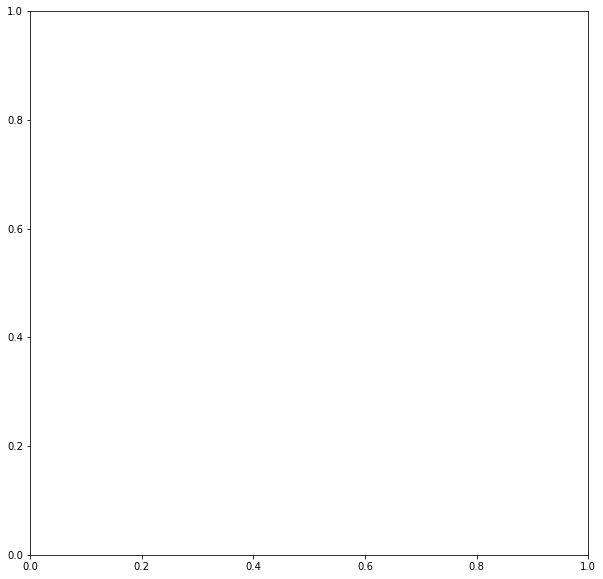

In [ ]:
print(len(res))
plt.figure(figsize=(10, 10))
plt.bar([0, 1, 2, 3, 4], training_res, width=0.5)

plt.title('Classification Age Training Set Prediction Result', fontsize=15)
plt.xlabel('Age Group (years old)', fontsize=15)
plt.ylabel('Prediction Accuracy (%)', fontsize=15)
plt.show()

[100.0, 98.0295566502463, 84.0, 71.7948717948718, 65.0]


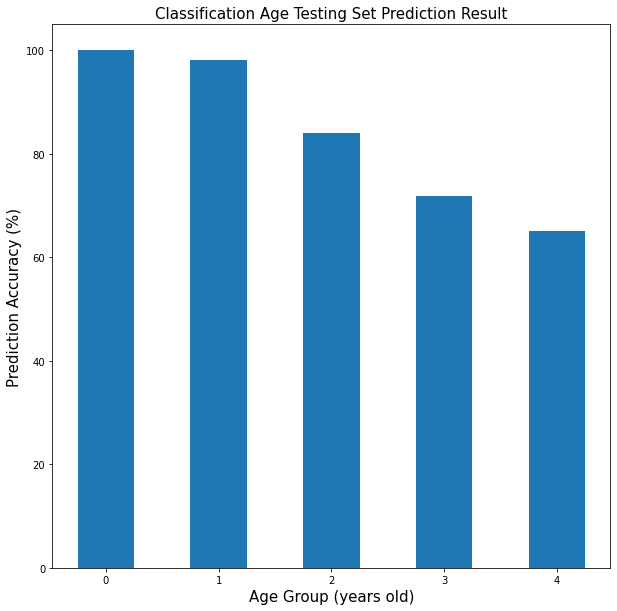

In [ ]:
plt.figure(figsize=(10, 10))
plt.bar([0, 1, 2, 3, 4], res[:5], width=0.5)
print(res)
plt.title('Classification Age Testing Set Prediction Result', fontsize=15)
plt.xlabel('Age Group (years old)', fontsize=15)
plt.ylabel('Prediction Accuracy (%)', fontsize=15)
plt.show()

In [ ]:
print(cm)

[[ 23.   1.   0.   0.   0.]
 [  0. 398.  13.   0.   0.]
 [  0.   7. 210.   7.   0.]
 [  0.   0.  23.  56.   7.]
 [  0.   0.   4.  15.  13.]]
